In [1]:
import pickle
import pandas as pd
from scipy import stats
from pyfaidx import Fasta
import pyranges as pr
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from kipoiseq.transforms.functional import one_hot_dna
import numpy as np
import torch
import torch.nn as nn
import logomaker

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(4, 128, 8),
             nn.ReLU(),
            nn.Conv1d(128,64,4),
            nn.ReLU(),
            nn.Conv1d(64,32,2),
             nn.BatchNorm1d(32),
              nn.MaxPool2d(2),
            nn.Dropout(0.4),
             nn.Flatten(),
            nn.Linear(1504, 32),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

    
    def feed_2_second_conv(self,x):
        """
        only encode x til layer 3
            Sequential(
              (0): Conv1d(4, 128, kernel_size=(8,), stride=(1,))
              (1): ReLU()
              (2): Conv1d(128, 64, kernel_size=(4,), stride=(1,))
              (3): ReLU()
            )
        """
        conv_trunc = self.conv[:4]
        feature_map = conv_trunc(x)
        return feature_map
        

In [5]:
checkpoint = torch.load("/mnt/ruiyanhou/nfs_share2/scTail/scTail/model/human_pretrained_model.pth",map_location='cuda:0')

In [6]:
ry_CNN = Net()

In [7]:
ry_CNN.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [8]:
fist_layer = ry_CNN.state_dict()['conv.0.weight']
fist_layer

tensor([[[ 0.1033,  0.1008, -0.0454,  ...,  0.1239, -0.0773, -0.0866],
         [-0.1461, -0.1085,  0.1199,  ...,  0.0438, -0.1070, -0.0493],
         [-0.1514, -0.0354,  0.0057,  ..., -0.0102, -0.1387,  0.0302],
         [ 0.1318,  0.0862, -0.1965,  ..., -0.1889, -0.2196,  0.0999]],

        [[-0.1242, -0.0498, -0.1281,  ..., -0.0624,  0.0205, -0.0099],
         [ 0.0937,  0.1094,  0.0652,  ...,  0.1454, -0.1411, -0.1474],
         [ 0.1670,  0.0836,  0.0169,  ..., -0.1258, -0.1303, -0.1404],
         [-0.2002, -0.1343,  0.1736,  ..., -0.0775,  0.1627, -0.0752]],

        [[-0.0549,  0.0361,  0.0477,  ...,  0.0713,  0.0133, -0.0831],
         [-0.0289,  0.1295, -0.1447,  ..., -0.2046, -0.0717, -0.1664],
         [ 0.0541,  0.0502, -0.2176,  ..., -0.1440,  0.0978, -0.0542],
         [ 0.1471, -0.0706, -0.1209,  ...,  0.2110, -0.0170,  0.0071]],

        ...,

        [[-0.0956, -0.0796, -0.0036,  ...,  0.1452, -0.0673, -0.1259],
         [-0.0691, -0.0439, -0.0017,  ..., -0.1420, -0.09

In [9]:
fist_layer.shape

torch.Size([128, 4, 8])

In [10]:
fist_layer.shape[0]

128

In [11]:
filter_dfs = []
for i in range(fist_layer.shape[0]):
    M = fist_layer[i].numpy().T
    print(M.shape)
    seq_logo_df = pd.DataFrame(M, columns=['A', 'C', 'T', 'G'])
    print(seq_logo_df)
    seq_logo_df = logomaker.transform_matrix(seq_logo_df, from_type='counts', to_type='information')
    print(seq_logo_df)
    filter_dfs.append(seq_logo_df)
    

(8, 4)
          A         C         T         G
0  0.103267 -0.146131 -0.151424  0.131767
1  0.100787 -0.108481 -0.035404  0.086189
2 -0.045432  0.119933  0.005683 -0.196506
3  0.115952 -0.085950  0.088549 -0.035453
4  0.201948 -0.033459 -0.041057 -0.055747
5  0.123866  0.043765 -0.010153 -0.188876
6 -0.077279 -0.107021 -0.138698 -0.219561
7 -0.086555 -0.049283  0.030174  0.099880
            A         C         G         T
pos                                        
0    0.003729  0.002886  0.003825  0.002868
1    0.001461  0.001183  0.001442  0.001280
2    0.002464  0.002891  0.002074  0.002596
3    0.001339  0.001097  0.001158  0.001306
4    0.002250  0.001809  0.001767  0.001795
5    0.002813  0.002613  0.002030  0.002478
6    0.000737  0.000713  0.000623  0.000688
7    0.000857  0.000892  0.001031  0.000966
(8, 4)
          A         C         T         G
0 -0.124169  0.093706  0.166960 -0.200249
1 -0.049826  0.109401  0.083555 -0.134339
2 -0.128113  0.065150  0.016869  0.173623


In [12]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

In [ ]:
with PdfPages('/mnt/ruiyanhou/nfs_share2/three_primer/human_model/explain_model/multipage_fistlayer_pdf.pdf') as pdf:
    
    for Round in range(8):
        fig,axs = plt.subplots(8,2, figsize=(8, 20),
                       gridspec_kw={"wspace":0.4, 'hspace':0.5})
        axs = axs.flatten()
        ax_count = 0
        for i in range(16*Round,16*(Round+1)):   
            ax = axs[ax_count]
            MA_C = logomaker.Logo(filter_dfs[i],ax=ax);
            ax.set_title("fist layer filter %d"%i)
            ax_count += 1
        pdf.savefig(fig)  # saves the current figure into a pdf page
        
    plt.close()
    

In [13]:
def one_hot(seq,complementary=False):
    """
    one_hot encoding on sequence
    seq : string, DNA / RNA nucleotide sequencess
    complementary: encode nucleatide into complementary one
    """
    # setting
    seq = list(seq.replace("U","T"))
    seq_len = len(seq)
    complementary = -1 if complementary else 1
    # compose dict
    keys = ['A', 'C', 'T', 'G'][::complementary]
    print(keys)
    oh_dict = {keys[i]:i for i in range(4)}
    # array
    oh_array = np.zeros((seq_len,4))
    for i,C in enumerate(seq):
        try:
            oh_array[i,oh_dict[C]]=1
        except:
            continue      # for nucleotide that are not in A C G T   
    return oh_array 

In [14]:
@torch.no_grad()
def featuremap_2nd(model, sequences):
    """
    for each input sequences, one hot encode and feed to the second layer
    Params
    -----------
    model : torch.nn.Module
    sequences : list of string, a list of DNA/RNA sequences
    
    Return
    -----------
    feature_map : np.ndarray, (n_sequences, L, n_channel), 
    the feature map at the second layer
    """
    fm_ls = []
    for seq in tqdm(sequences):
        oh_x = one_hot(seq).T.astype(np.float32)
        x_ts = torch.from_numpy(oh_x).unsqueeze(0) # -> [1,L,4]
        
        featuremap = model.feed_2_second_conv(x_ts)
        fm_ls.append(featuremap.squeeze().numpy()) 
    
    return np.stack(fm_ls)
    

In [15]:
bedfile=pd.read_csv('/mnt/ruiyanhou/nfs_share2/three_primer/PBMC/run_scTail/PBMC866_GXfiltered_without_umitools/count/input_to_DP.tsv',delimiter='\t')
bedfile

Chromosome Strand       PAS                cluster_id
0           chr1      +    629433      chr1_+_629404_629433
1           chr1      +    630023      chr1_+_629941_630023
2           chr1      +    630449      chr1_+_630405_630449
3           chr1      +    630680      chr1_+_630635_630680
4           chr1      +    632198      chr1_+_632111_632198
...          ...    ...       ...                       ...
21944       chrY      -  13234578  chrY_-_13234578_13234614
21945       chrY      -  13479064  chrY_-_13479064_13479108
21946       chrY      -  19705418  chrY_-_19705418_19705436
21947       chrY      -  19710005  chrY_-_19710005_19710045
21948       chrY      -  19715149  chrY_-_19715149_19715164

[21949 rows x 4 columns]

In [16]:
ref_fastq='/mnt/ruiyanhou/nfs_share2/annotation/annotation_from_Gencode/GRCh38.primary_assembly.genome.fa'
genes=Fasta(ref_fastq)

In [17]:
bedfile['start']=bedfile['PAS']-100
bedfile['end']=bedfile['PAS']+100

In [18]:
#extract sequence and do one-hot encoding 
onehotdict={}
for chrom, start, end, strand, genename in tqdm(bedfile[['Chromosome','start','end','Strand','cluster_id']].values,desc='Loading Loci'):
    if strand=='+':
        seq_=genes.get_seq(chrom,start+1,end).seq
    else:
        seq_=genes.get_seq(chrom,start+1,end,rc=True).seq
    onehotdict[genename]=seq_

onehotdict

Loading Loci: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21949/21949 [00:04<00:00, 5356.85it/s]


{'chr1_+_629404_629433': 'ACACCTCCTATGAAAAAACTTCCTACCACTCACCCTAGCATTACTTATATGATATGTCTCCATACCCATTACAATCTCCAGCATTCCCCCTCAAACCTAAGAAATATGTCTGATAAAAGAGTTACTTTGATAGAGTAAATAATAGGAGTTTAAATCCCCTTATTTCTAGGACTATGAGAATCGAACCCATCCCTGAGAAT',
 'chr1_+_629941_630023': 'ATTAATAATCATAATGGCTATAGCAATAAAACTAGGAATAGCCCCCTTTCACTTCTGAGTCCCAGAGGTTACCCAAGGCACCCCTCTGACATCCGGCCTGCTCCTTCTCACATGACAAAAACTAGCCCCCATCTCAATCATATACCAAATTTCTCCCTCATTAAACGTAAGCCTTCTCCTCACTCTTTCAATCTTATCCA',
 'chr1_+_630405_630449': 'AACATGACTAACACCCTTAATTCCATCCACCCTCCTCTCCCTAGGAGGCCTGCCCCCGCTAACCGGCTTTTTGCCCAAATGGGCCATTATCGAAGAATTCACAAAAAACAATAGCCTCATCATCCCCACCATCATAGCCATCATCACCCTCCTTAACCTCTACTTCTACCTGCGCCTAATCTACTCCACCTCAATCACAC',
 'chr1_+_630635_630680': 'ATGACAGTTTGAACACACAAAACCCACCCCATTCCTCCCCACACTCATCGCCCTTACCACACTGCTCCTACCTATCTCCCCTTTTATGCTAATAATCTTATAGAAATTTAGGTTAAATACAGACCAAGAGCCTTCAAAGCCCTCAGTAAGTTGCAATACTTAATTTCTGCAACAGCTAAGGACTGCAAAACCCCACTCTG',
 'chr1_+_632111_632198': 'TAGGATTTATTTTTCTTTTCACCGTAGGTGGCCTGACTGGCATTGTATTAGCAAACTC

In [19]:
test_data=pd.DataFrame(onehotdict,index=[0])
test_data=test_data.T
test_data.reset_index(inplace=True)
test_data.columns=['name','sequence']
test_data

name  \
0          chr1_+_629404_629433   
1          chr1_+_629941_630023   
2          chr1_+_630405_630449   
3          chr1_+_630635_630680   
4          chr1_+_632111_632198   
...                         ...   
21944  chrY_-_13234578_13234614   
21945  chrY_-_13479064_13479108   
21946  chrY_-_19705418_19705436   
21947  chrY_-_19710005_19710045   
21948  chrY_-_19715149_19715164   

                                                sequence  
0      ACACCTCCTATGAAAAAACTTCCTACCACTCACCCTAGCATTACTT...  
1      ATTAATAATCATAATGGCTATAGCAATAAAACTAGGAATAGCCCCC...  
2      AACATGACTAACACCCTTAATTCCATCCACCCTCCTCTCCCTAGGA...  
3      ATGACAGTTTGAACACACAAAACCCACCCCATTCCTCCCCACACTC...  
4      TAGGATTTATTTTTCTTTTCACCGTAGGTGGCCTGACTGGCATTGT...  
...                                                  ...  
21944  GAGCTGCAGAGATGACCAGAAGACCTGCATCCAGAGAGGAGCTTCC...  
21945  CTCTGCTCCATGGCCAAGGGGTCGGAAAAGTGTTTCTTGCCTTTGC...  
21946  AAGAATAGGGAAAAACAAGAATTTCATGACTCTACCTGTGGTCTAT...  
21947  GGTTGGTTGGTTGATTTCCCTCCAGACACCAGAGTCTTAGAAAGCT...  
21948  GAATTGTTTGAACCCAGGAGACAGAGGTTGCAGTGAGCCGAGATGG...  

[21949 rows x 2 columns]

In [20]:
model = ry_CNN.eval()

In [21]:
test_fm = featuremap_2nd(model, test_data['sequence'].values)


test_fm.shape

  0%|                                                                                                                                                                                                     | 0/21949 [00:00<?, ?it/s]

['A', 'C', 'T', 'G']


  2%|██▊                                                                                                                                                                                       | 337/21949 [00:00<00:23, 931.13it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

  3%|█████▋                                                                                                                                                                                   | 677/21949 [00:00<00:15, 1340.01it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

  5%|████████▌                                                                                                                                                                               | 1019/21949 [00:00<00:13, 1527.33it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

  6%|███████████▍                                                                                                                                                                            | 1369/21949 [00:01<00:12, 1640.66it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

  8%|██████████████▌                                                                                                                                                                         | 1731/21949 [00:01<00:11, 1700.13it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

  9%|█████████████████▍                                                                                                                                                                      | 2078/21949 [00:01<00:11, 1714.81it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 10%|██████████████████▊                                                                                                                                                                     | 2251/21949 [00:01<00:11, 1696.08it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 12%|█████████████████████▊                                                                                                                                                                  | 2595/21949 [00:01<00:11, 1706.86it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 14%|████████████████████████▉                                                                                                                                                               | 2979/21949 [00:01<00:10, 1819.12it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 16%|█████████████████████████████▉                                                                                                                                                          | 3574/21949 [00:02<00:09, 1927.93it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 17%|███████████████████████████████▌                                                                                                                                                        | 3767/21949 [00:02<00:09, 1894.98it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 19%|██████████████████████████████████▊                                                                                                                                                     | 4155/21949 [00:02<00:09, 1902.52it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 21%|██████████████████████████████████████▏                                                                                                                                                 | 4551/21949 [00:02<00:08, 1939.72it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 23%|█████████████████████████████████████████▍                                                                                                                                              | 4949/21949 [00:03<00:08, 1963.40it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 24%|████████████████████████████████████████████▊                                                                                                                                           | 5345/21949 [00:03<00:08, 1970.78it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 26%|████████████████████████████████████████████████                                                                                                                                        | 5739/21949 [00:03<00:08, 1931.70it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 28%|███████████████████████████████████████████████████▍                                                                                                                                    | 6131/21949 [00:03<00:08, 1892.30it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 30%|██████████████████████████████████████████████████████▌                                                                                                                                 | 6515/21949 [00:03<00:08, 1906.04it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 31%|█████████████████████████████████████████████████████████▊                                                                                                                              | 6902/21949 [00:04<00:07, 1918.11it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 33%|█████████████████████████████████████████████████████████████                                                                                                                           | 7286/21949 [00:04<00:07, 1913.05it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 35%|████████████████████████████████████████████████████████████████▎                                                                                                                       | 7668/21949 [00:04<00:07, 1887.46it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 37%|███████████████████████████████████████████████████████████████████▍                                                                                                                    | 8046/21949 [00:04<00:07, 1878.60it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 38%|██████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8431/21949 [00:04<00:07, 1902.22it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 40%|█████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8815/21949 [00:05<00:06, 1910.92it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 42%|█████████████████████████████████████████████████████████████████████████████                                                                                                           | 9199/21949 [00:05<00:06, 1843.82it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9575/21949 [00:05<00:06, 1809.80it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 45%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9962/21949 [00:05<00:06, 1871.55it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 47%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 10352/21949 [00:05<00:06, 1910.80it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 49%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10743/21949 [00:06<00:05, 1930.17it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 51%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 11132/21949 [00:06<00:05, 1936.25it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 52%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 11520/21949 [00:06<00:05, 1931.90it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 11908/21949 [00:06<00:05, 1930.11it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12295/21949 [00:06<00:05, 1921.10it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 12683/21949 [00:07<00:04, 1926.26it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 13069/21949 [00:07<00:04, 1867.75it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 13444/21949 [00:07<00:04, 1832.78it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 13815/21949 [00:07<00:04, 1829.36it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 14198/21949 [00:07<00:04, 1872.13it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 14575/21949 [00:08<00:03, 1876.79it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 14958/21949 [00:08<00:03, 1895.28it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 15337/21949 [00:08<00:03, 1877.74it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 15723/21949 [00:08<00:03, 1903.42it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 16108/21949 [00:08<00:03, 1912.49it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 16493/21949 [00:09<00:02, 1907.15it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 16875/21949 [00:09<00:02, 1898.33it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 17259/21949 [00:09<00:02, 1907.76it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 17642/21949 [00:09<00:02, 1905.62it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 18024/21949 [00:09<00:02, 1903.59it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 18406/21949 [00:10<00:01, 1888.87it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 18784/21949 [00:10<00:01, 1839.20it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 19151/21949 [00:10<00:01, 1804.08it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 19510/21949 [00:10<00:01, 1758.58it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 19867/21949 [00:10<00:01, 1746.39it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 20248/21949 [00:11<00:00, 1824.47it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 20629/21949 [00:11<00:00, 1861.48it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 21008/21949 [00:11<00:00, 1877.33it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 21389/21949 [00:11<00:00, 1890.13it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 21769/21949 [00:11<00:00, 1891.31it/s]

['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21949/21949 [00:12<00:00, 1822.51it/s]


['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T', 'G']
['A', 'C', 'T

(21949, 64, 190)

In [22]:
# padding
p = 0

# kernel size
k_2 = 4
k_1 = 8

# stride
s_2 = 1
s_1 = 1

r = (k_1 - 1)*s_1 + (k_2 -1 )*s_2 +1

print('receptive field of the second layer is ',r)

receptive field of the second layer is  11


In [23]:
def locate_seq(fm_position):
    """
    Given a feature in the second layer feature map, locate the sequence region contributed.
    Params:
    -------
    fm_position : int \in [0,190), the location in FM 
    
    Return:
    -------
    slice : [u_0, v_0) python indexing variable
        u_0: the leftmost position of the sequence, closed
        v_0: the rightmost position of the sequence, open
    """
    # left
    u_2 = fm_position
    u_1 = u_2 * s_2 
    u_0 = u_1 * s_1

    # right
    v_2 = fm_position
    v_1 = v_2 * s_2 + k_2 -1
    v_0 = v_1 * s_1 + k_1 -1
    
    return slice(max(u_0,0), min(v_0+1,200))
    

In [24]:
locate_seq(0)

slice(0, 11, None)

In [25]:
def find_most_activating_seq(feature_map, sequences, n_patch):
    """
    Using the extracted featuremap, find the samples that give rise to the highest activation. 
    Within the sequences, retieve the regions that mostly activate each channel
    Params:
    ---------
    feature_map: np.ndarray, 
    sequences : list of sequences,
    n_patch : threshold, defining the number of top most activated values
    
    Return
    --------
    Seqlet : ndarray. 64 * n_patch. Each element is a sub sequence which we called seqlet.
    """
    Seqlet = []
    for channel in range(feature_map.shape[1]):
        # print(channel)
        
        # determine which sample gives the most activated neuron
        channel_feature = feature_map[:, channel,:]
        # print(channel_feature)
        # print(channel_feature.shape)
        F0_ay = channel_feature.max(axis=-1) #
        # print(F0_ay.shape)
        max_n_index = np.argpartition(F0_ay, -1*n_patch, axis=0)[-1*n_patch:]
        # print(max_n_index)

        # subset the sequence with the largest activation
        Max_sequences = sequences[max_n_index]
        #print(Max_sequences)
        # print("the length")
        # print(len(Max_sequences))
        # print(len(Max_sequences[0]))
        
        # retieve the position in feature map and trace back to region in the sequence
        Act_sites = np.argmax(channel_feature[max_n_index],axis=1)

        print(channel_feature.shape)
        print(max_n_index)
        print(Act_sites)
        
        #print(Act_sites)
        mapped_input_region = [locate_seq(site) for site in Act_sites]
        
        # slice the region
        Seqlet.append(
            [seq[region] for seq, region in zip(Max_sequences, mapped_input_region)]
        )
         
    return Seqlet
    

In [26]:
channel=3

channel_feature=test_fm[:,channel,:]
channel_feature

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
channel_feature.shape

activate_=channel_feature.mean(axis=0)

In [28]:
df=pd.DataFrame(activate_)
df

0
0    0.000624
1    0.000477
2    0.000658
3    0.000665
4    0.000666
..        ...
185  0.000568
186  0.000599
187  0.000630
188  0.000651
189  0.000602

[190 rows x 1 columns]

In [29]:
df['ture_position']=range(-100,90)
df.columns=['Weights','ture_position']
df

Weights  ture_position
0    0.000624           -100
1    0.000477            -99
2    0.000658            -98
3    0.000665            -97
4    0.000666            -96
..        ...            ...
185  0.000568             85
186  0.000599             86
187  0.000630             87
188  0.000651             88
189  0.000602             89

[190 rows x 2 columns]

In [30]:
df.sort_values('Weights').tail(20)

Weights  ture_position
63  0.002384            -37
82  0.002468            -18
64  0.002630            -36
65  0.003296            -35
66  0.003588            -34
81  0.004124            -19
67  0.004197            -33
68  0.004841            -32
69  0.005906            -31
80  0.006794            -20
70  0.007157            -30
71  0.008907            -29
79  0.009232            -21
72  0.010679            -28
73  0.012237            -27
78  0.012426            -22
74  0.013792            -26
77  0.014460            -23
75  0.015107            -25
76  0.015556            -24

In [31]:
def plot_distribution(filter_num):
    channel_feature=test_fm[:,filter_num,:]
    activate_=channel_feature.mean(axis=0)
    df=pd.DataFrame(activate_)
    df['ture_position']=range(-100,90)
    df.columns=['Weights','ture_position']

    fig, ax = plt.subplots(figsize=(7,5))
    plt.rcParams['font.size'] = 16
    
    ax.plot(df['ture_position'], df['Weights'],color='black')
    ax.axvline(x=0, color='red', linestyle='--')
    title='2nd layer filter %i'%(filter_num)
    ax.set(xlabel='Relative distance to PAS (nt)', ylabel='Average strength importance',
           title=title)


    output='/mnt/ruiyanhou/nfs_share2/three_primer/figure/2nd_layer_'+str(filter_num)+'.pdf'
    fig.savefig(output,dpi=300,bbox_inches='tight')
    plt.show()
    

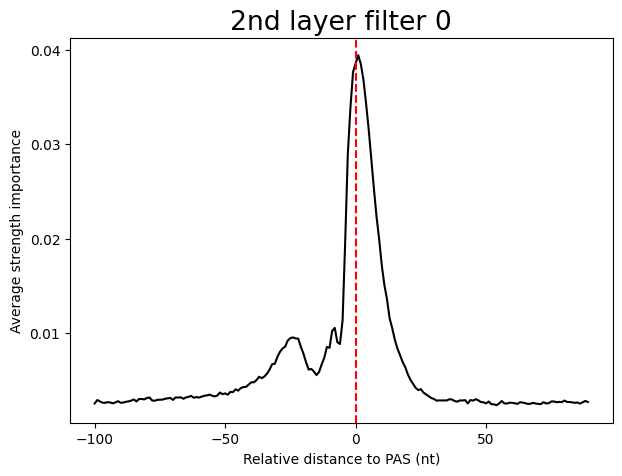

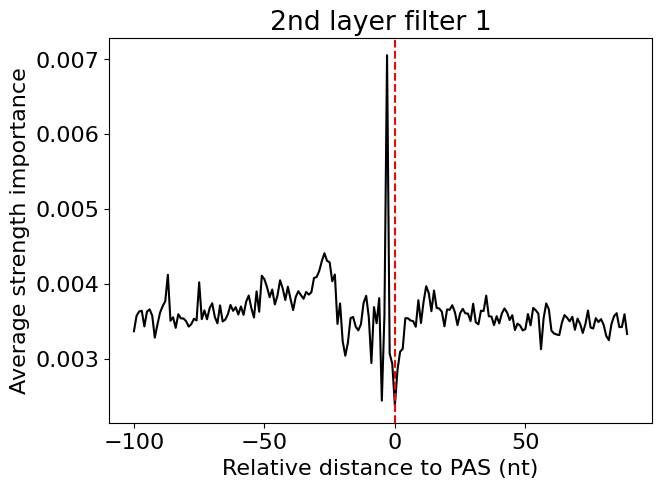

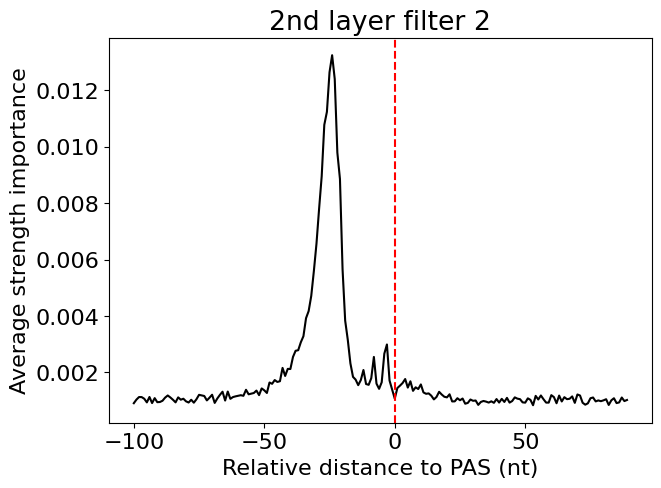

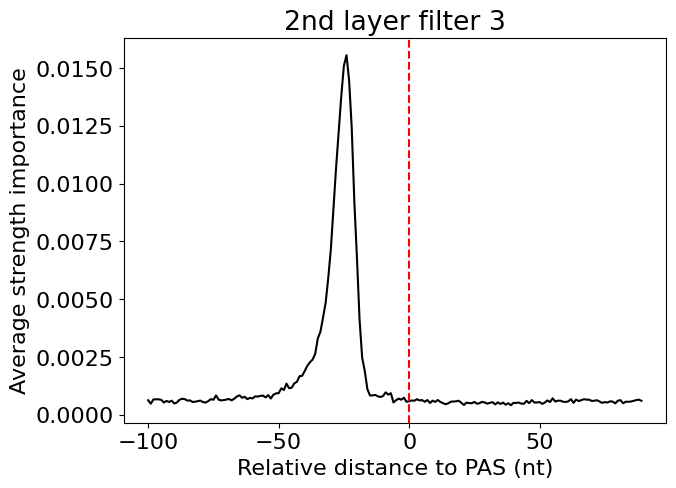

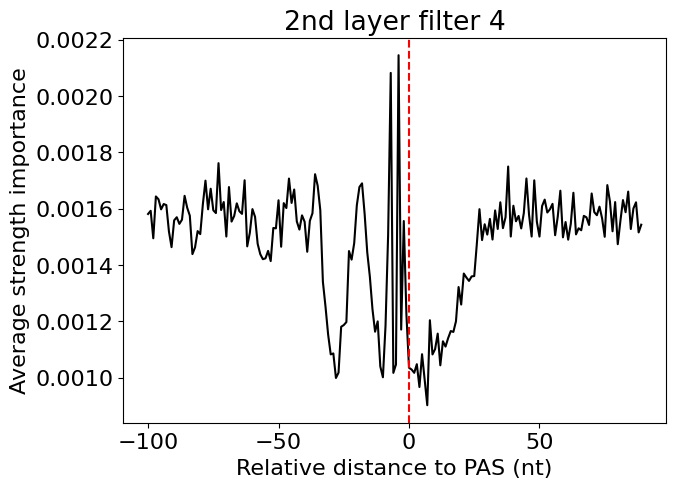

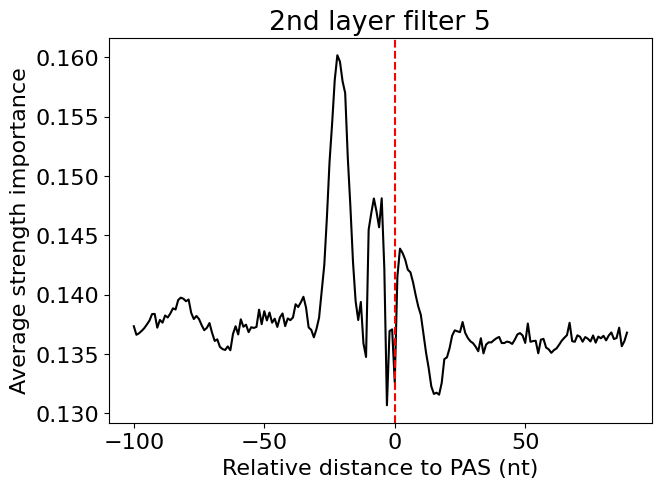

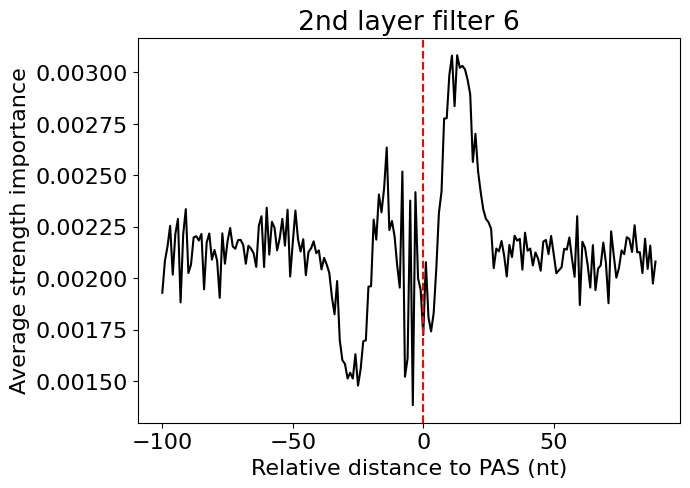

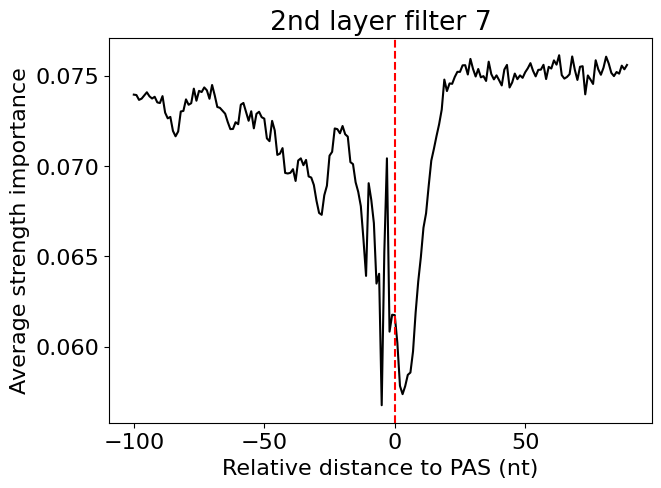

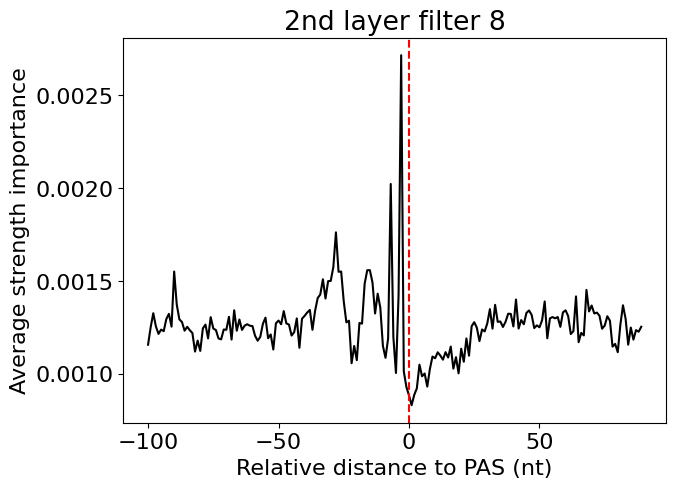

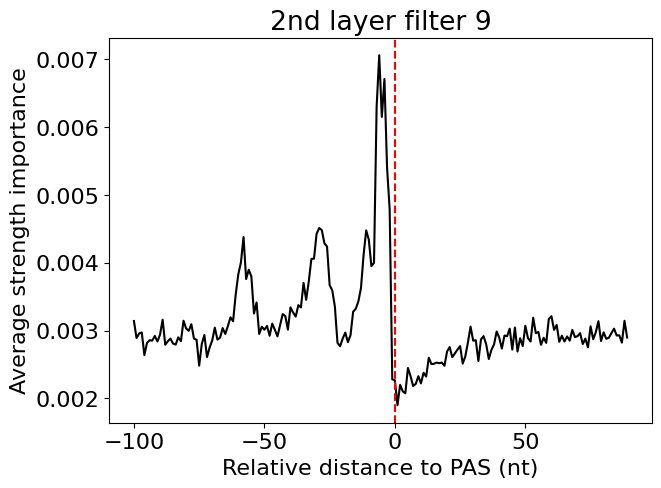

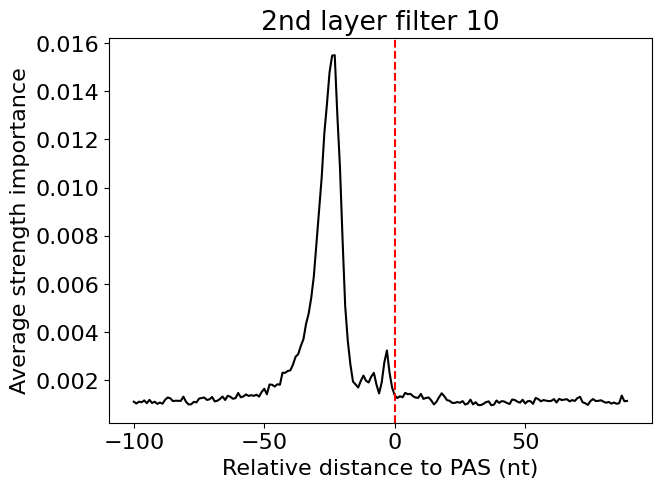

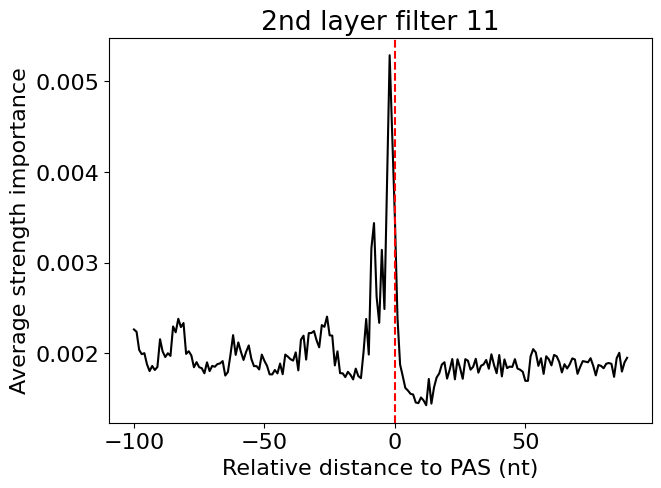

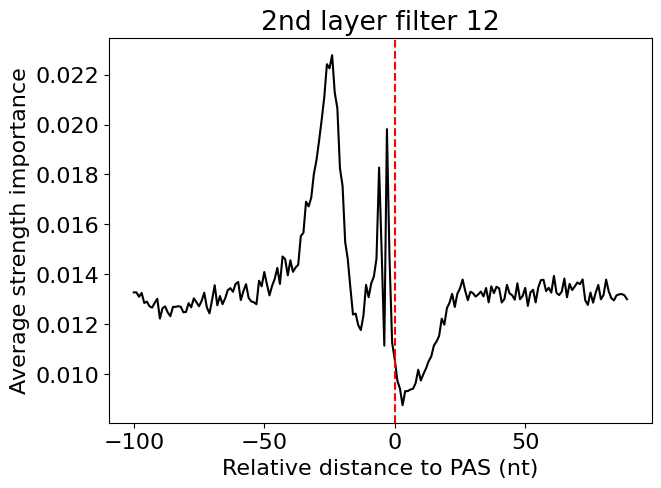

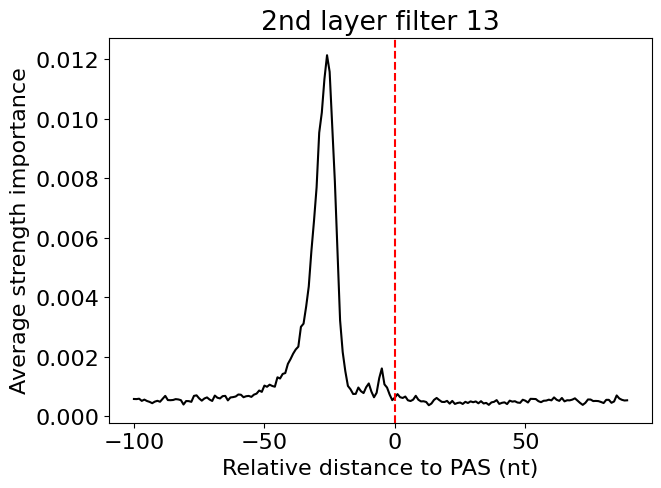

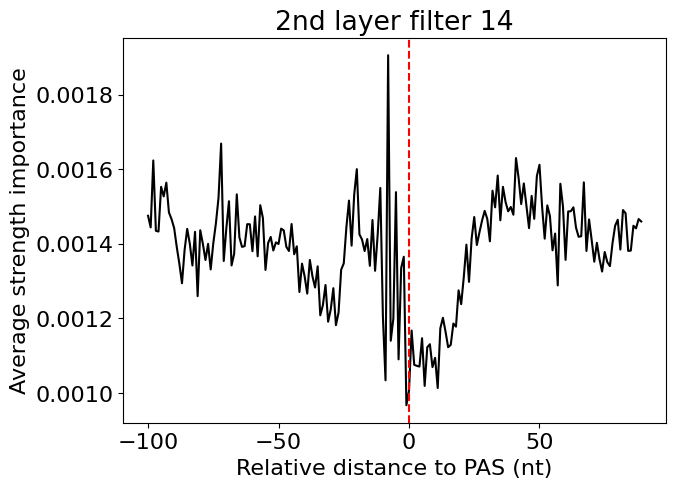

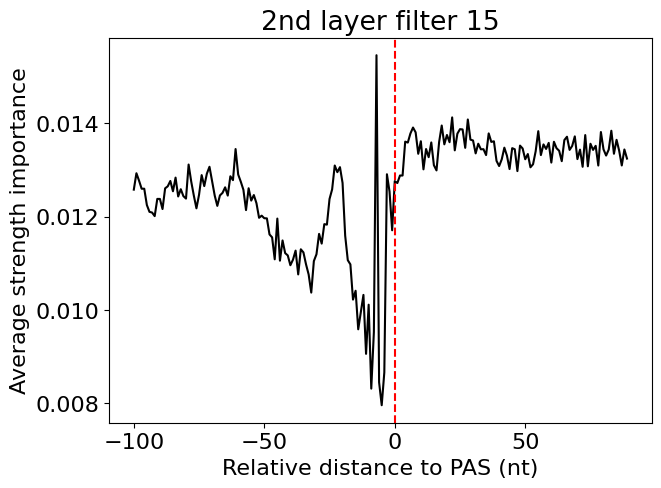

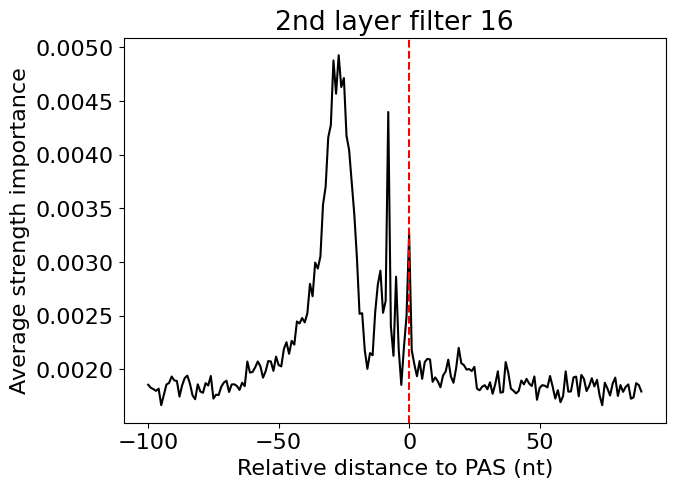

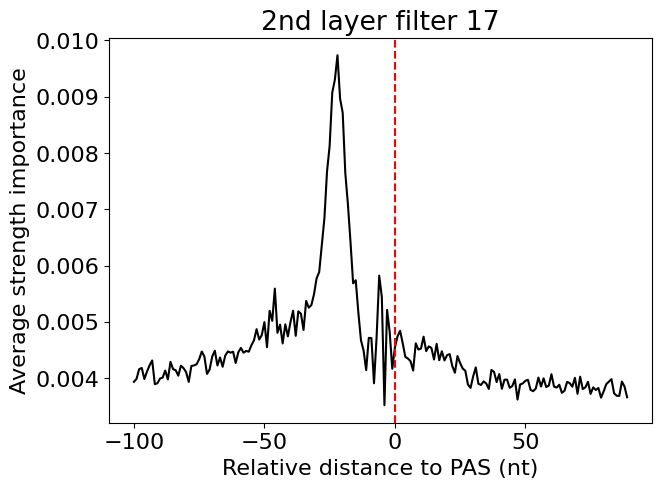

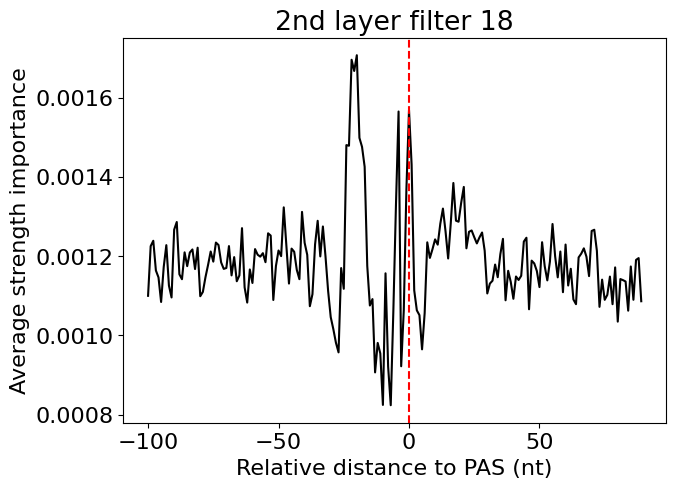

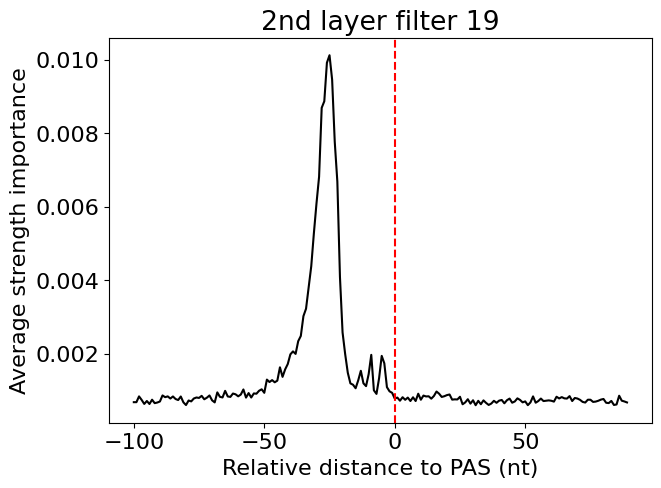

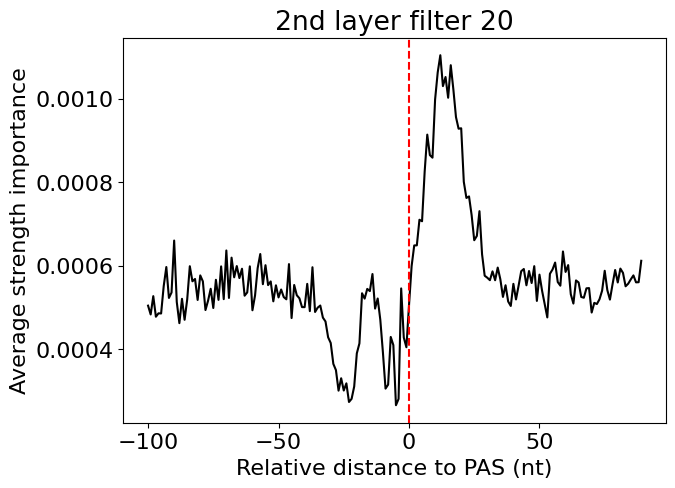

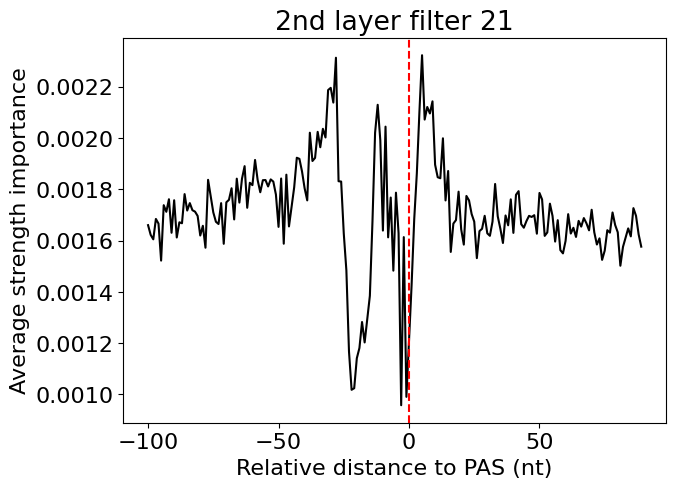

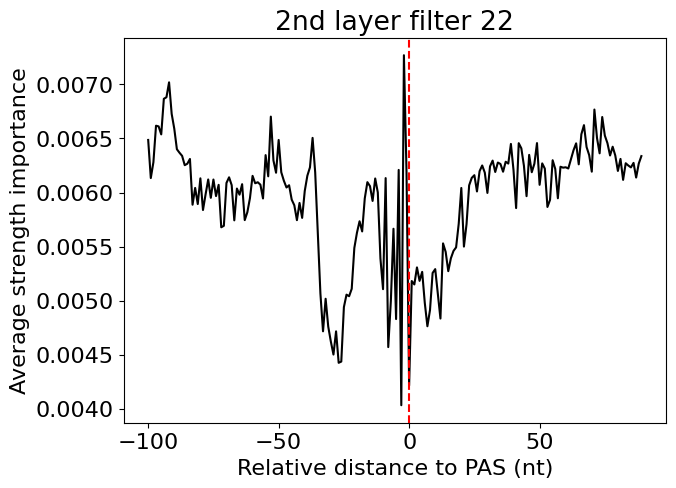

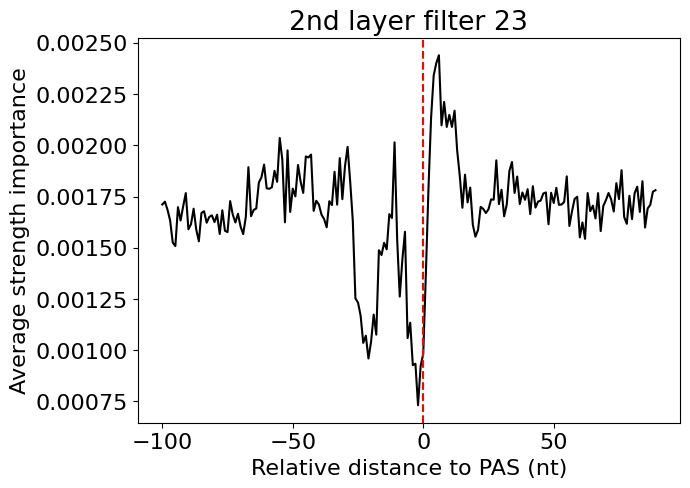

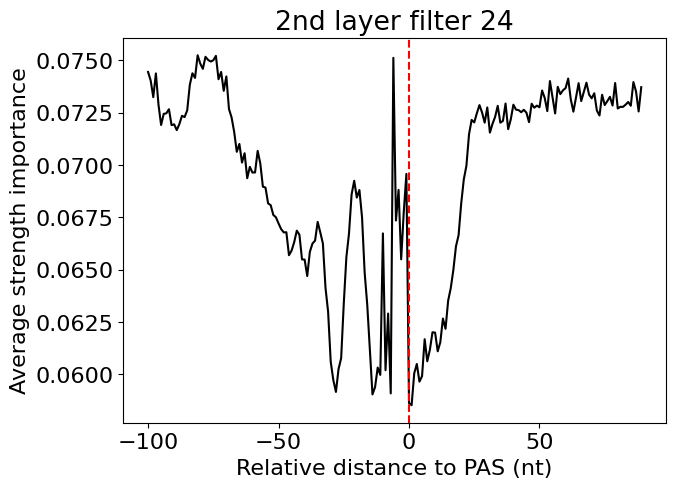

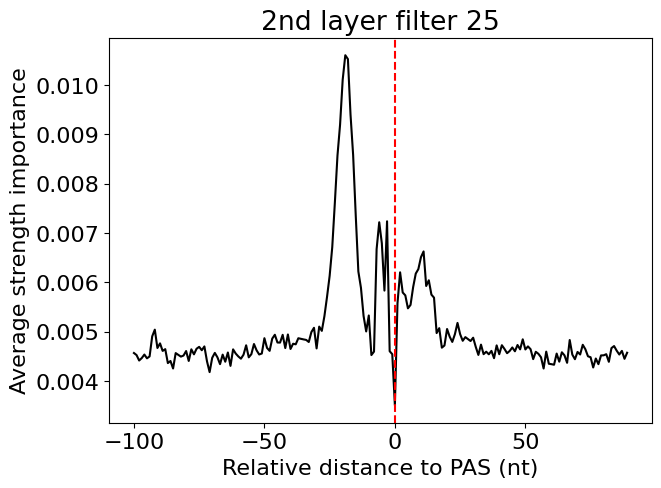

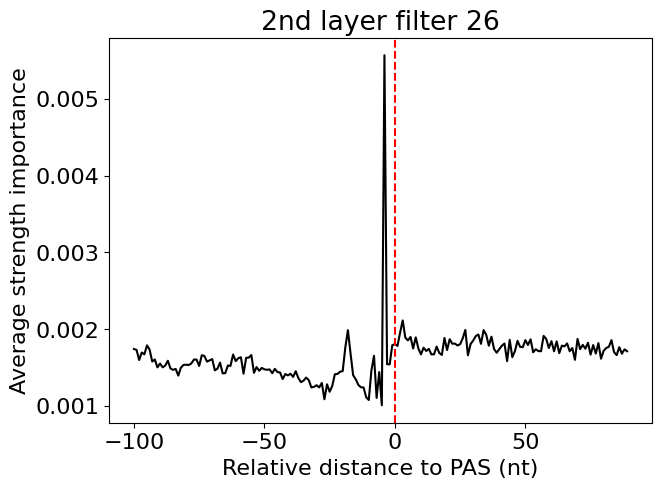

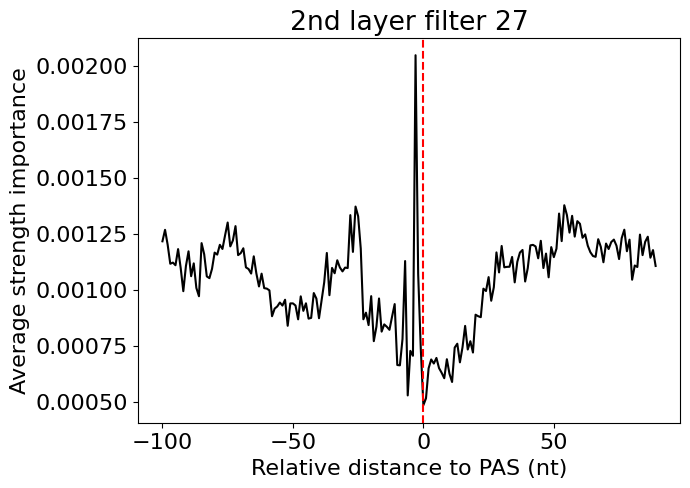

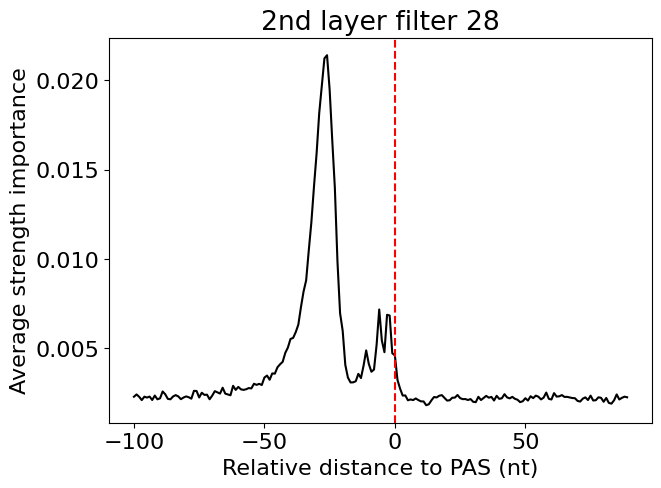

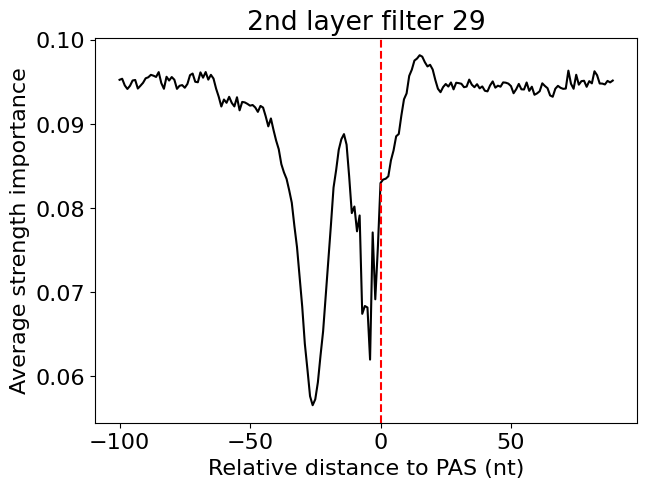

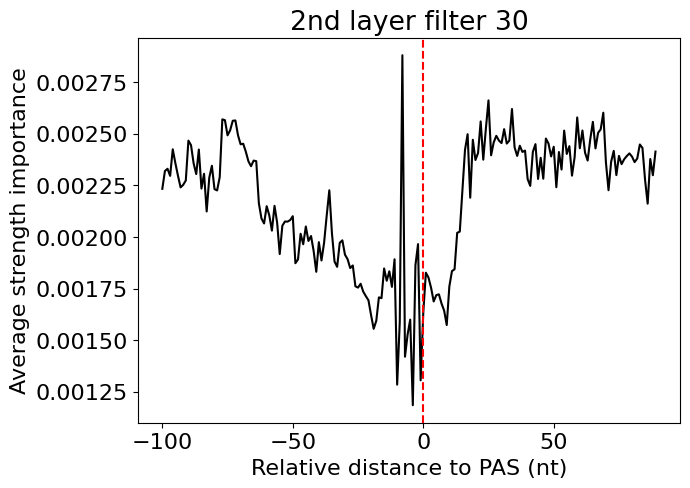

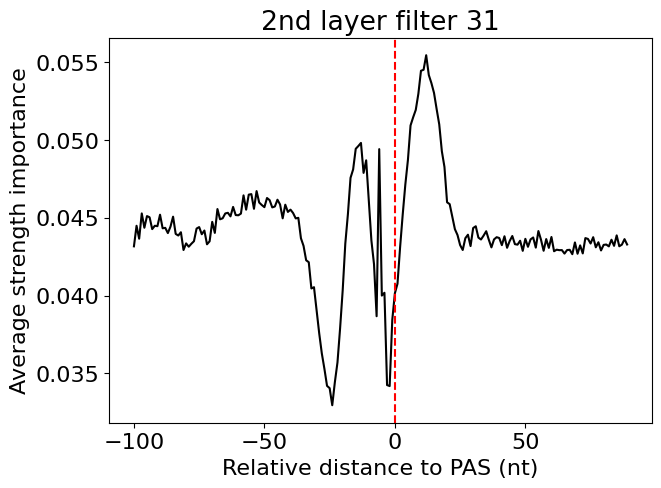

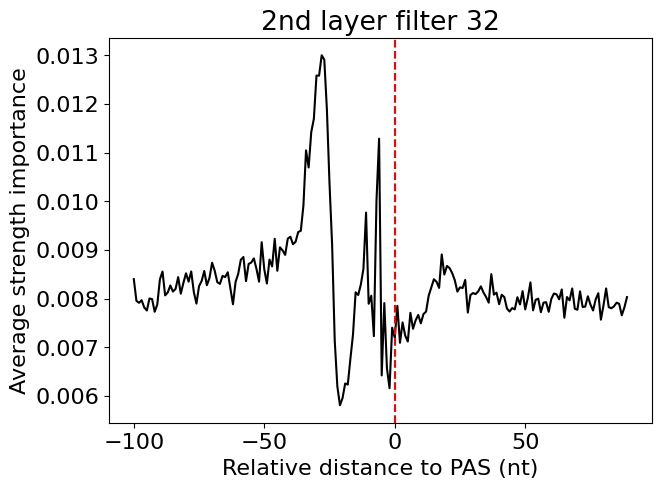

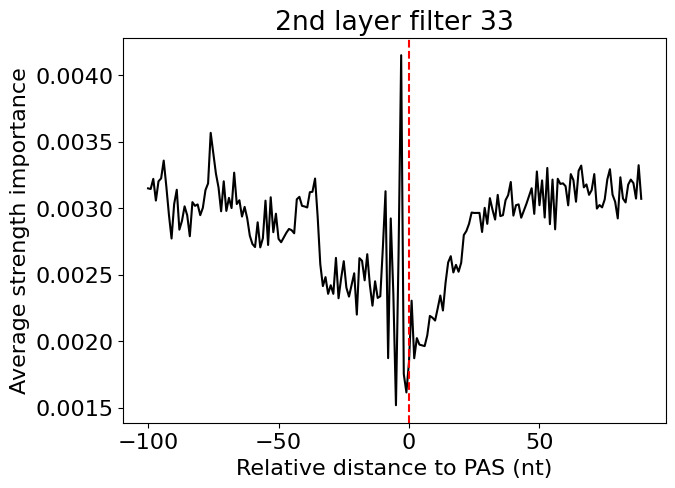

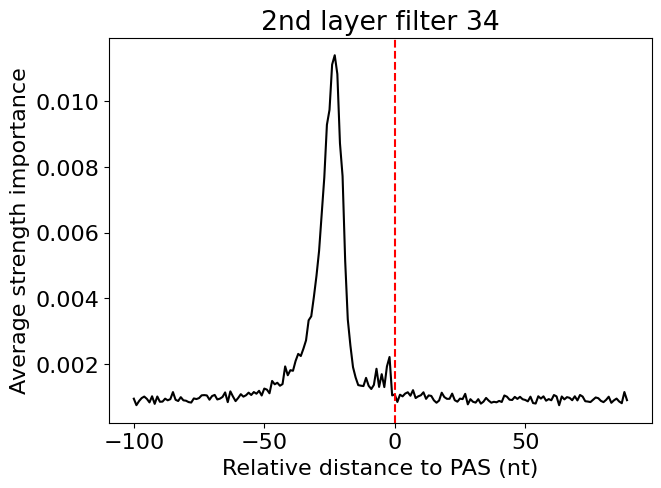

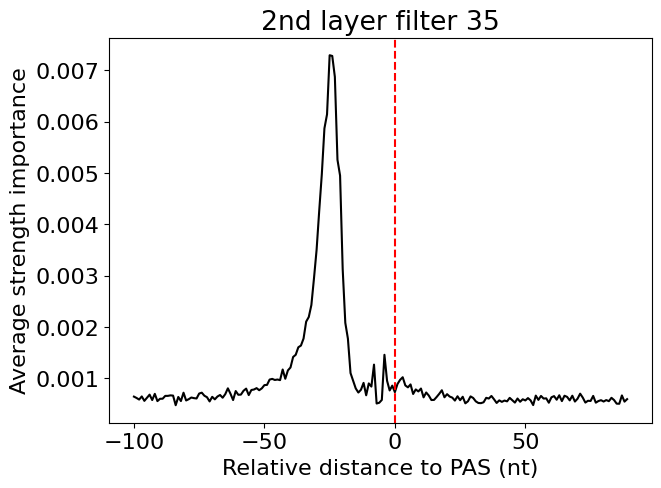

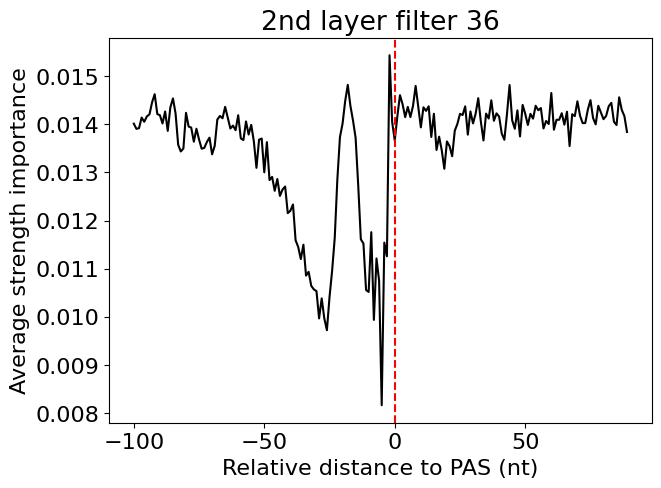

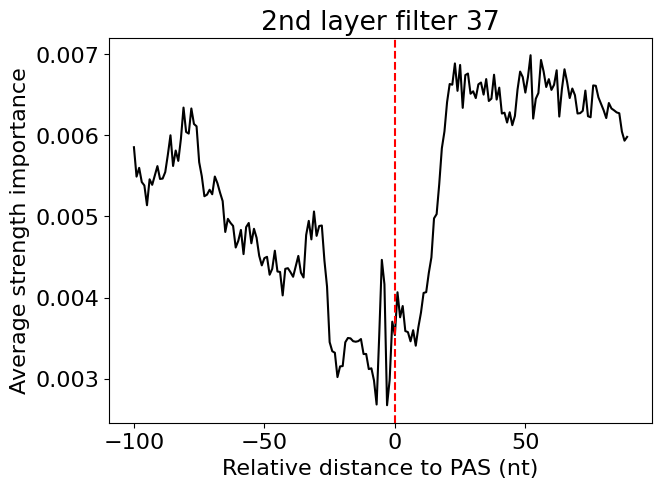

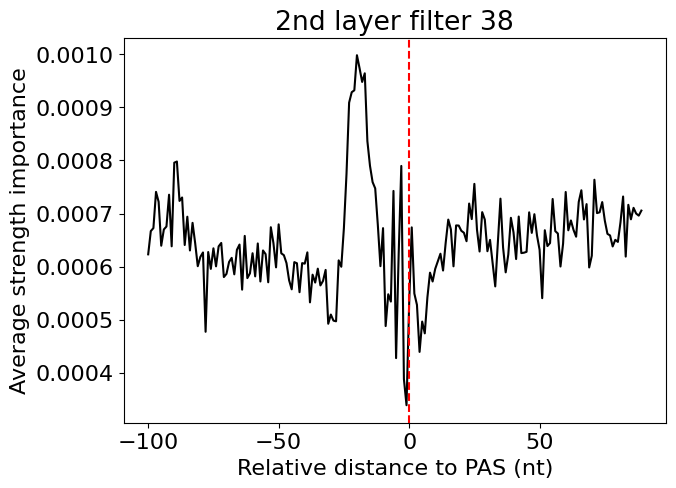

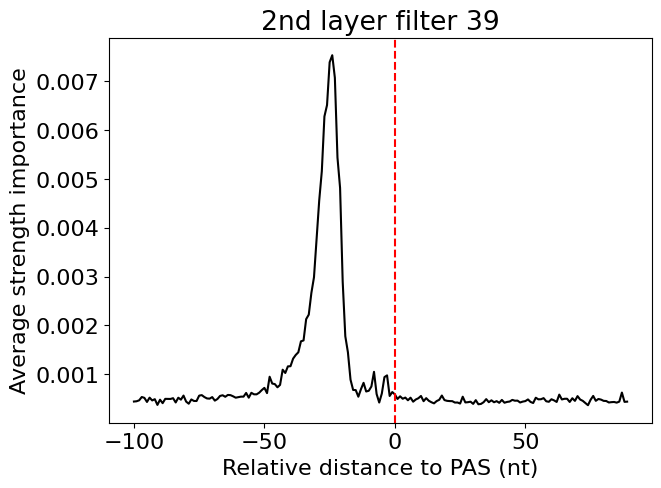

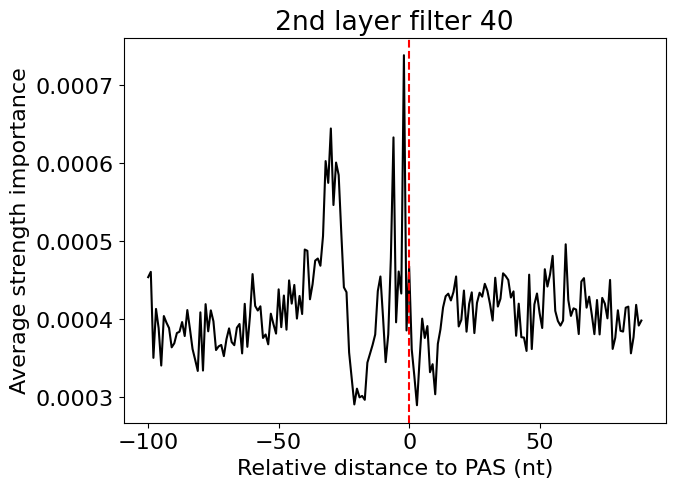

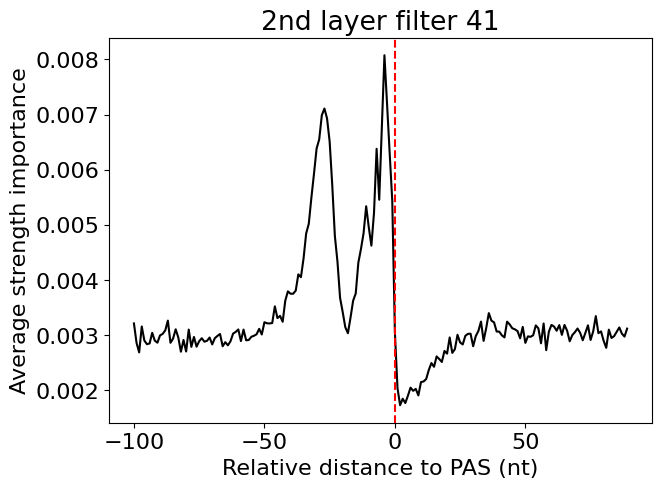

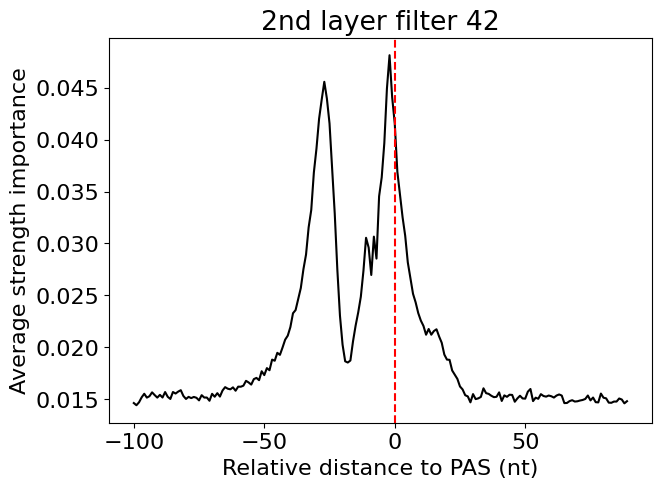

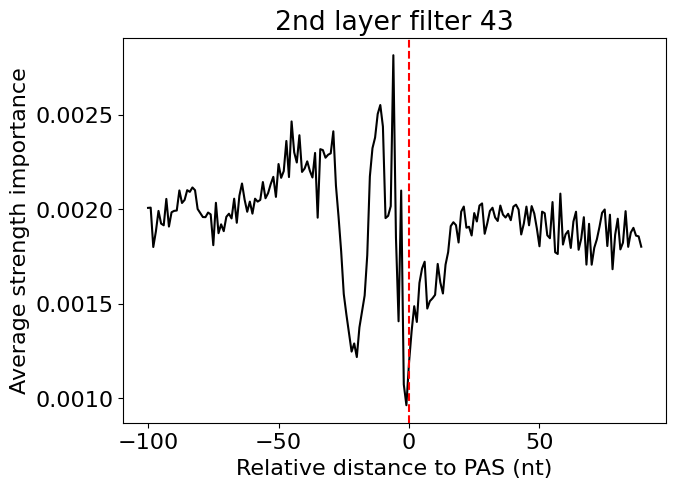

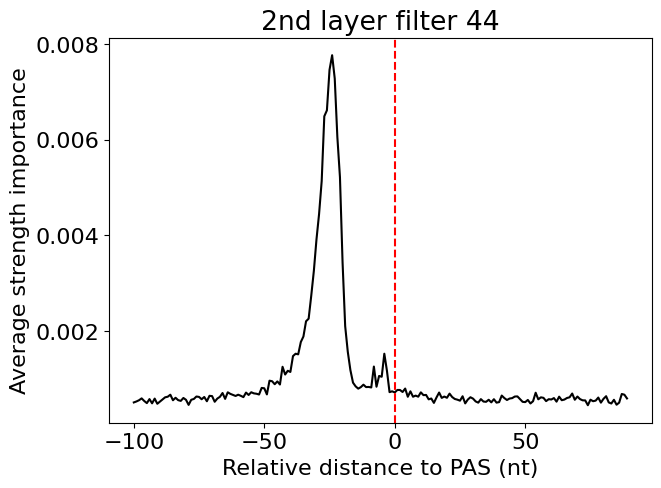

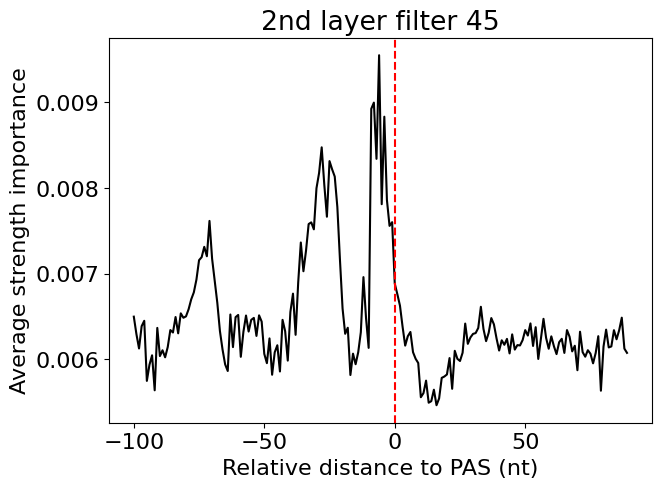

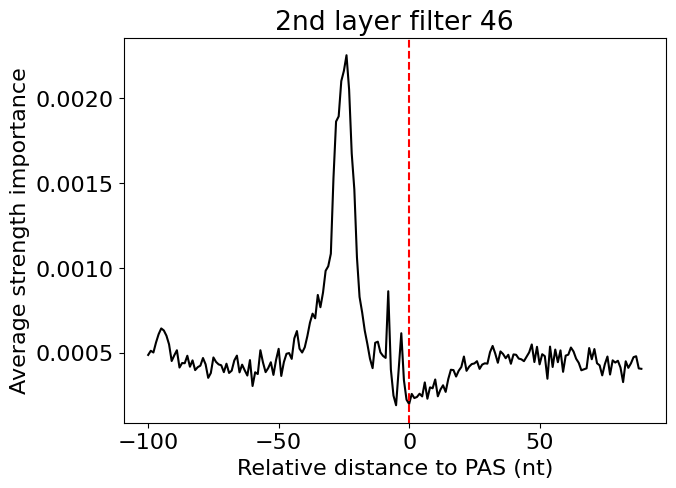

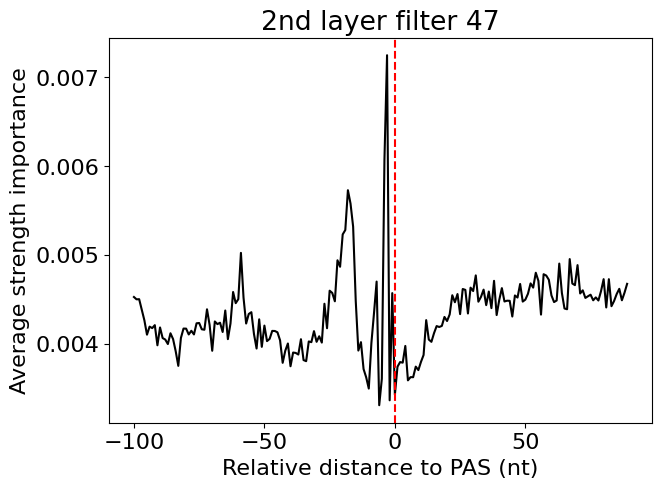

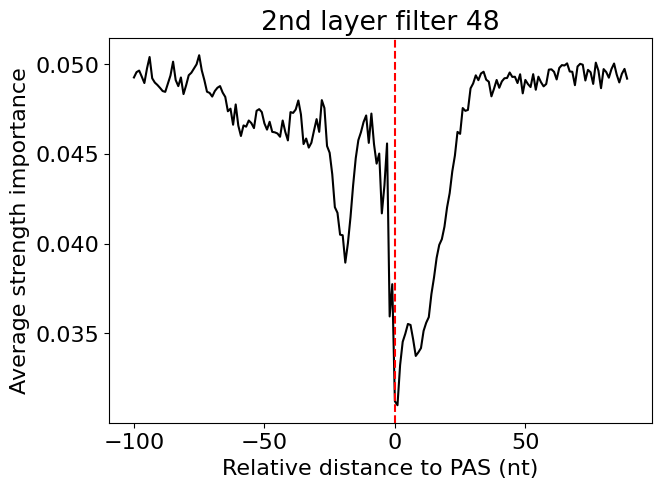

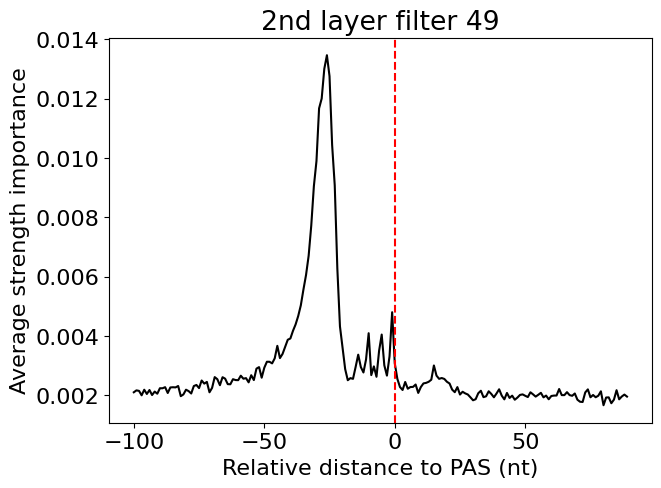

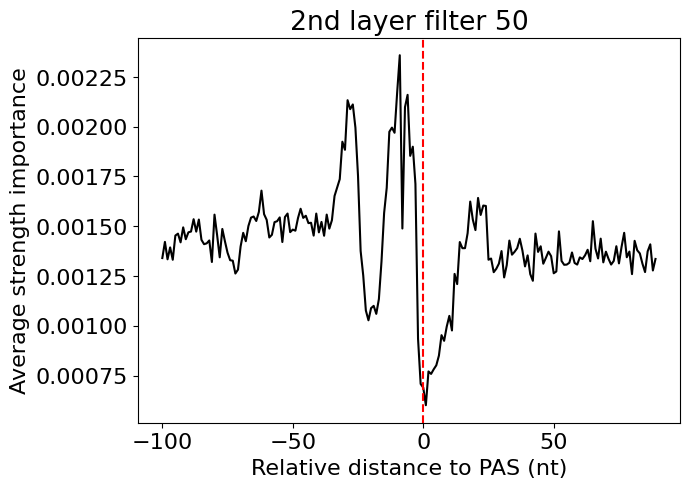

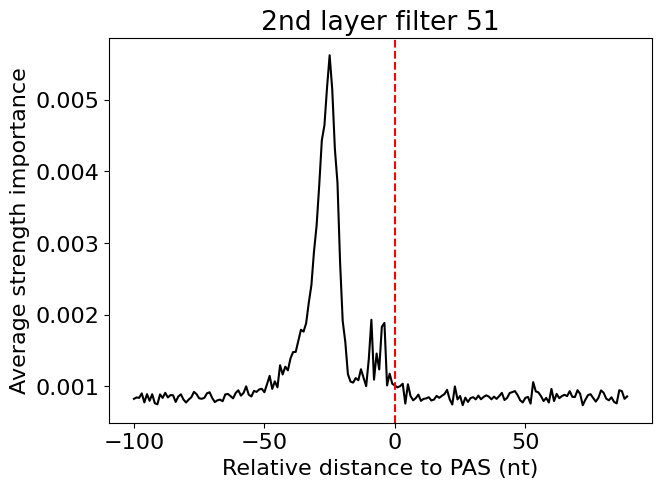

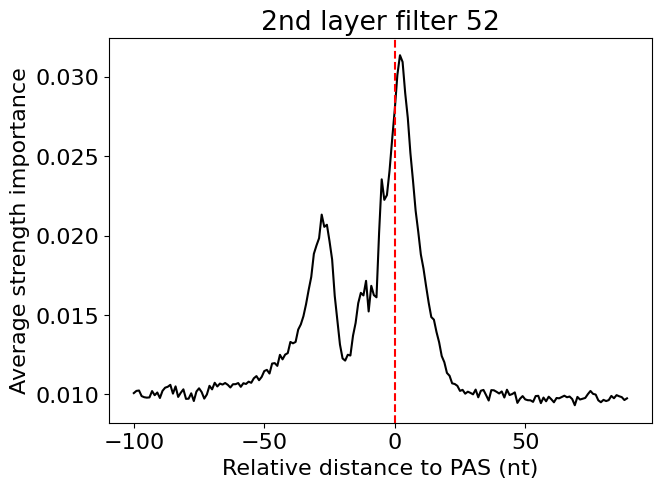

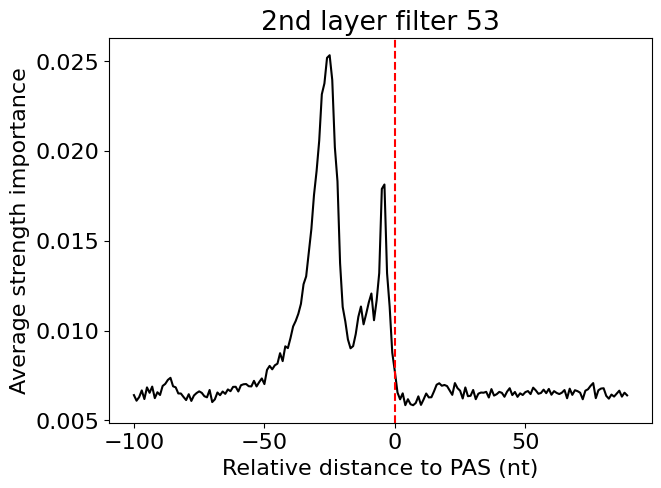

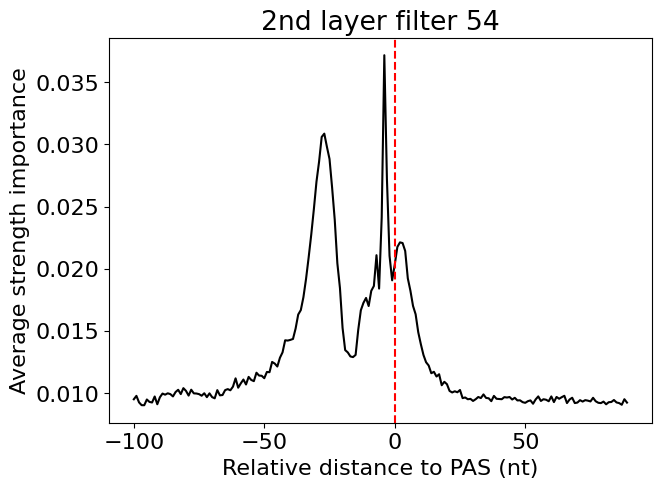

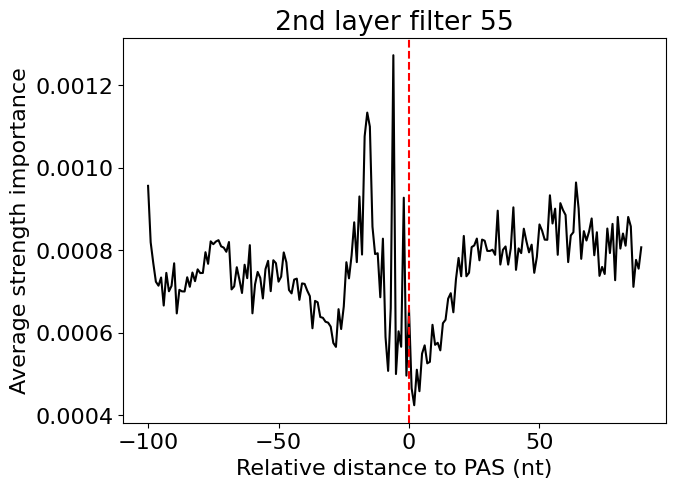

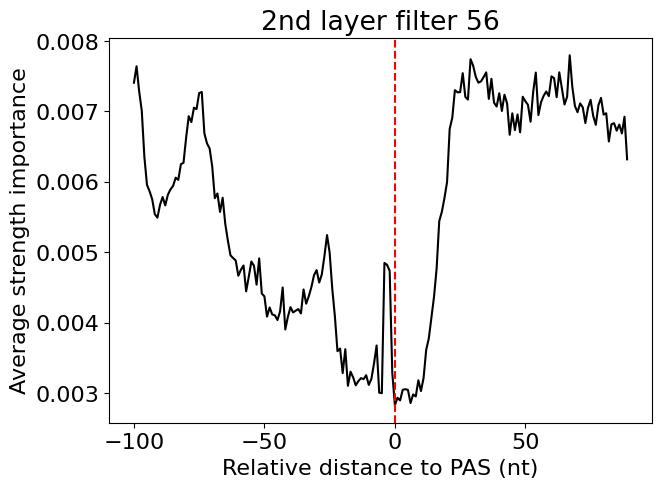

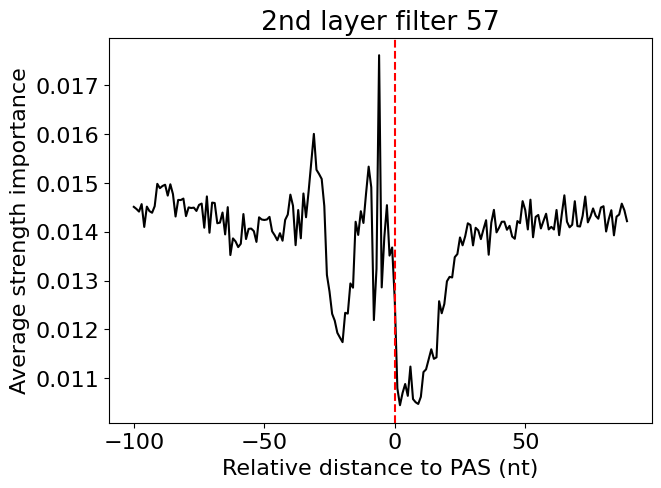

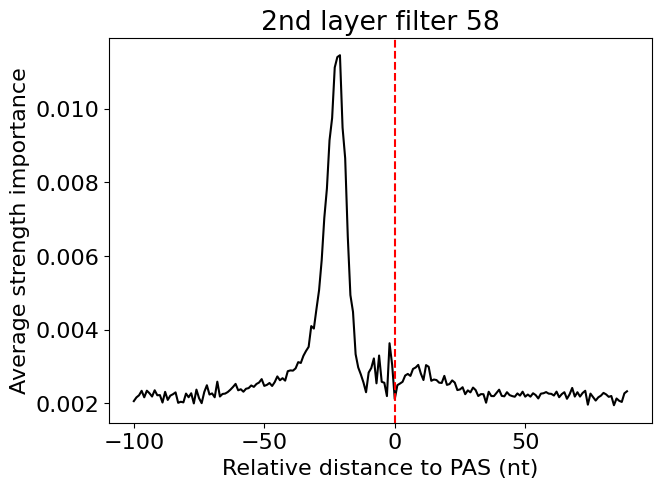

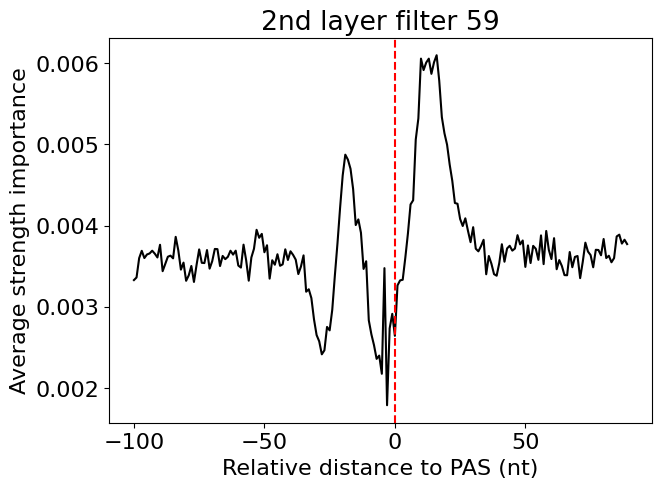

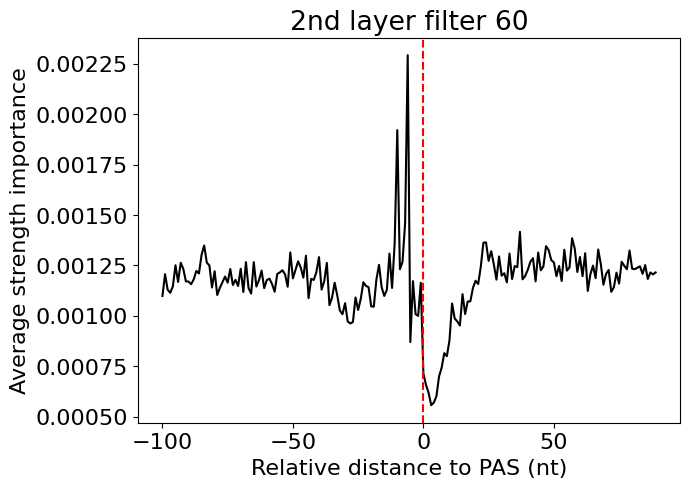

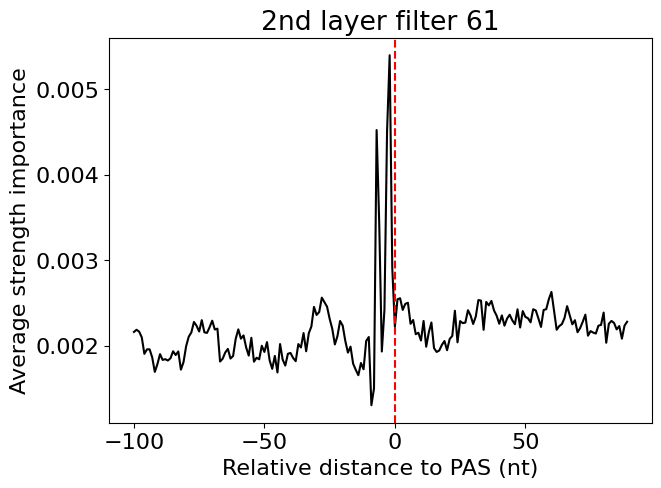

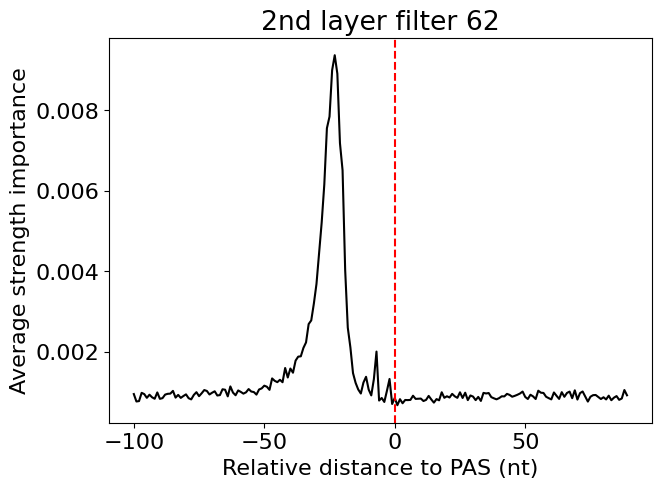

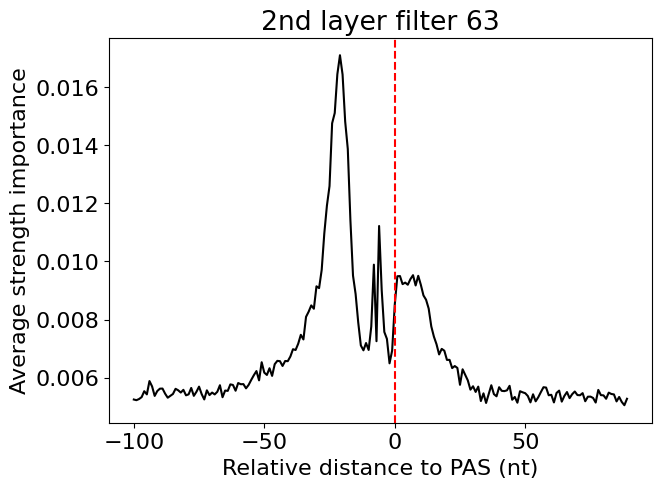

IndexError: index 64 is out of bounds for axis 1 with size 64

In [32]:
    

for i in range(0,65):
    plot_distribution(i)

In [33]:
# very important parameters !!!!!!!!!!
n_patch = 50

test_seqlet = find_most_activating_seq(test_fm, test_data['sequence'].values, n_patch)

(21949, 190)
[18069  4574 20368 16560 13357  5032 13372  4550 14354  5669  1906 18203
 14969 10259 20611 14966 21416 18157  7854  3600 21498   714  5574  1177
 11704  8352  3926 14331   144  3399 18483 20476  8806 13938 19609  1593
 12187 16264 16991  5884  7865  7416   429  5788 16408 21872 20731  8699
 17975 19610]
[172 101  55  67  96 105 125 126 106  27 118 125 110 102 178 102  62  47
 105  68  70   4 185  65  54 151  33  99 111   7  97 101  78 128  25  74
 107 142  99 116  47  90  89  41 151  71  63  56  62 123]
(21949, 190)
[ 2497 21659 18167 13694 16404  3366 21422  2183 20841 13550  4412 10147
 10539  9572 17666 15431 14575  8220 19077 18945 18944  7737 18782 18781
  6212   628 15973 21066  3341  3351  6107 11422  1237 13242 16658  7528
 21403  1685 11967   438  9806 13676 21643  2551 20091   490  7408  3779
 20043  9052]
[157  88  57 187 143  55  45 153 139  75 187  16  60 136  94 113 104  24
 120  96 166 123  31 168  97 110 109 129  69 101 167 125  31 118  71 144
 173  16  89

In [34]:
len(test_seqlet)

64

In [35]:
len(test_seqlet[0])

50

In [36]:
# plot the seqlet
print(test_seqlet[0][:])

['AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'ACATAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'ACATAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'AAAGAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACAGAAAAATA', 'ACATAAAAATA', 'ACAGAAAAATA', 'ACAGAAAAATA', 'ACAGAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACAGAAAAATA', 'ACAGAAAAATA', 'ACAGAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACATAAAAATA', 'ACAGAAAAATA', 'ACATAAAAATA', 'ACAGAAAAATA']


In [37]:
def sequence_to_matrix(max_act_region, n_patch, transformation='information', weight=None):
    """
    Turn the extracted seqlet into PWMs
    """
    assert np.all([seq != "" for seq in max_act_region])

    max_len = max([len(seq) for seq in max_act_region])
    #print(max_len)

    M = np.zeros((max_len,4))
    #print(M)
    if weight is None:
        weight = np.ones((n_patch,))
        print(weight)
    for seq, w in zip(max_act_region, weight):
        oh_M = one_hot(seq)*w
        print(oh_M)
        M += np.concatenate([np.zeros((max_len - len(seq),4)), oh_M],axis=0)


    seq_logo_df = pd.DataFrame(M, columns=['A', 'C', 'T', 'G'])
    if transformation!='counts':
        seq_logo_df = logomaker.transform_matrix(seq_logo_df, from_type='counts', to_type=transformation)

    return seq_logo_df
    

In [38]:
test_PWM = [sequence_to_matrix(channel_seqlet, n_patch) for channel_seqlet in test_seqlet]


test_PWM[:2]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
['A', 'C', 'T', 'G']
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
['A', 'C', 'T', 'G']
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
['A', 'C', 'T', 'G']
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
['A', 'C', 'T', 'G']
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
['A', 'C', 'T', 'G']
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [

[            A         C         G         T
 pos                                        
 0    1.513381  0.029674  0.029674  0.029674
 1    0.371445  0.371445  0.014286  0.014286
 2    1.513381  0.029674  0.029674  0.029674
 3    0.015860  0.015860  0.555101  0.269621
 4    1.513381  0.029674  0.029674  0.029674
 5    1.513381  0.029674  0.029674  0.029674
 6    1.513381  0.029674  0.029674  0.029674
 7    1.513381  0.029674  0.029674  0.029674
 8    1.513381  0.029674  0.029674  0.029674
 9    0.029674  0.029674  0.029674  1.513381
 10   1.513381  0.029674  0.029674  0.029674,
             A         C         G         T
 pos                                        
 0    0.954927  0.127324  0.021221  0.042441
 1    0.044081  0.543662  0.014694  0.191016
 2    0.014978  0.299552  0.479283  0.014978
 3    0.019524  0.195242  0.820018  0.019524
 4    0.029674  0.029674  0.029674  1.513381
 5    1.513381  0.029674  0.029674  0.029674
 6    0.096763  0.110587  0.013823  0.525286
 7    0.0

In [39]:
len(test_PWM)

64

In [40]:
test_PWM[0]

A         C         G         T
pos                                        
0    1.513381  0.029674  0.029674  0.029674
1    0.371445  0.371445  0.014286  0.014286
2    1.513381  0.029674  0.029674  0.029674
3    0.015860  0.015860  0.555101  0.269621
4    1.513381  0.029674  0.029674  0.029674
5    1.513381  0.029674  0.029674  0.029674
6    1.513381  0.029674  0.029674  0.029674
7    1.513381  0.029674  0.029674  0.029674
8    1.513381  0.029674  0.029674  0.029674
9    0.029674  0.029674  0.029674  1.513381
10   1.513381  0.029674  0.029674  0.029674

In [41]:
def plot_motif(filter_no):
    logomaker.Logo(test_PWM[filter_no])
    plt.title('2nd layer filter %d'%filter_no)
    #outputfile='/mnt/ruiyanhou/nfs_share2/three_primer/model_explain/second_layer_motif/filter_'+str(filter_no)+'.pdf'
    #plt.savefig(outputfile,dpi=300,bbox_inches='tight')

In [43]:
import warnings 
warnings.filterwarnings('ignore')

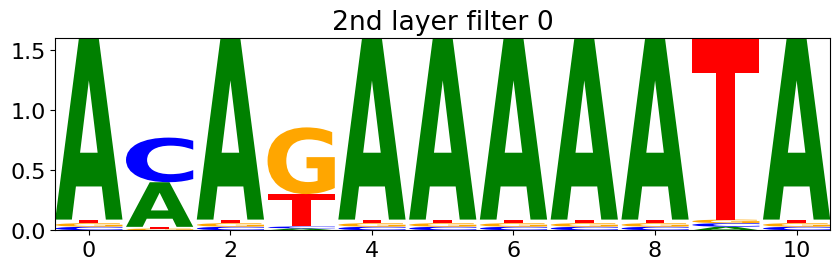

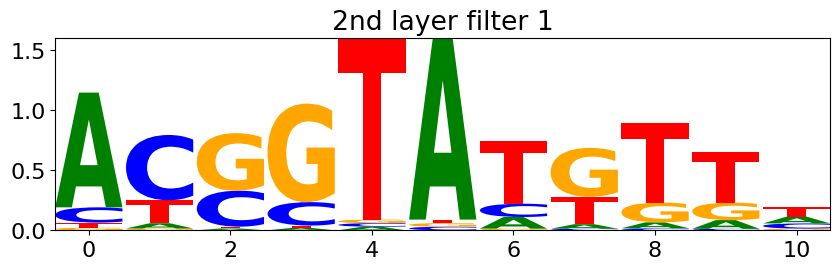

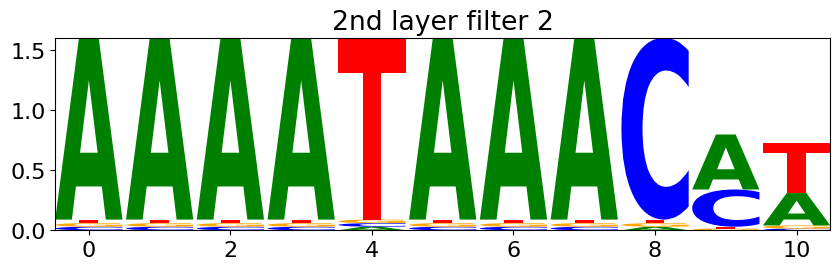

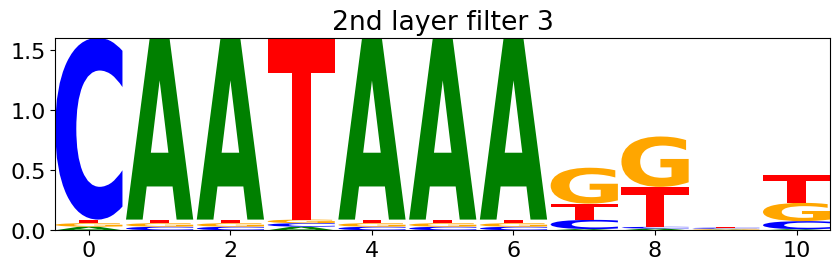

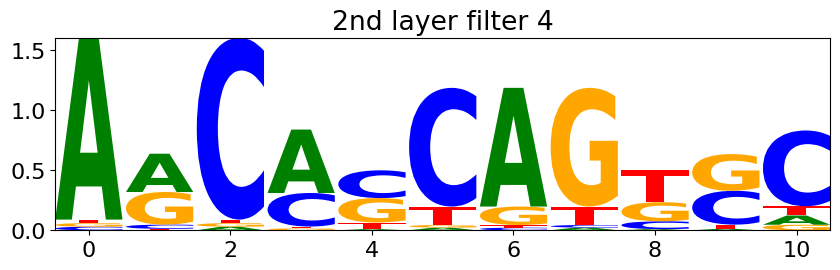

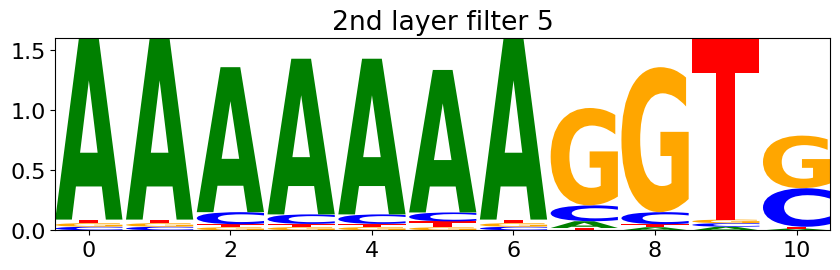

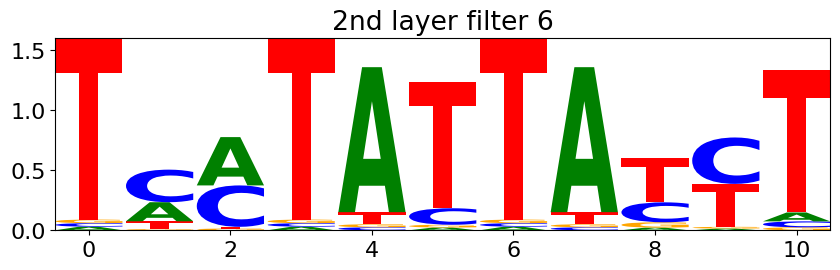

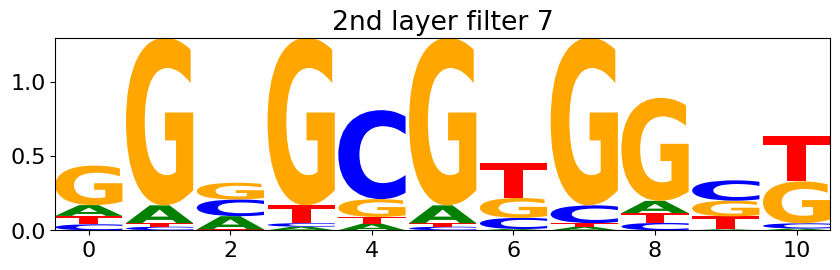

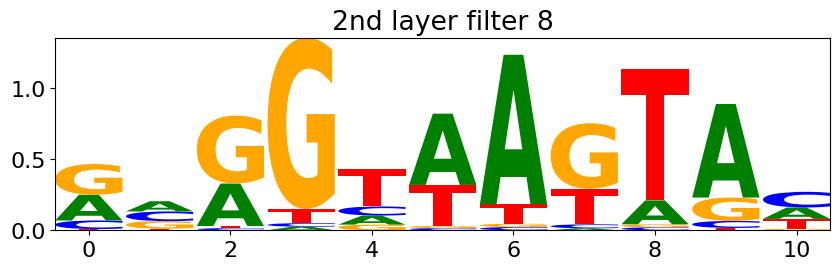

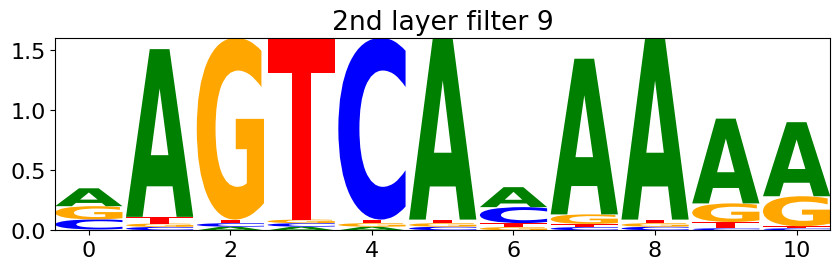

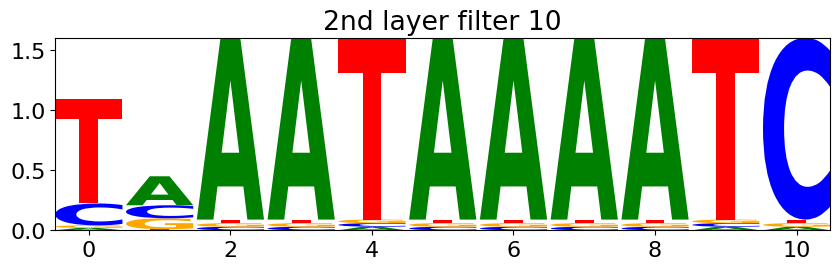

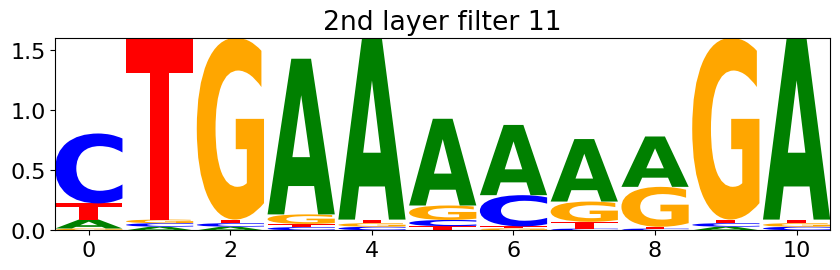

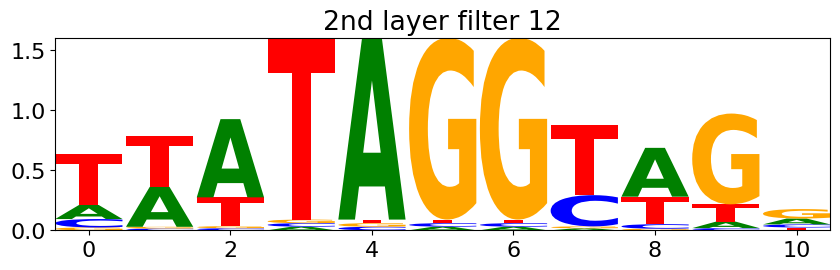

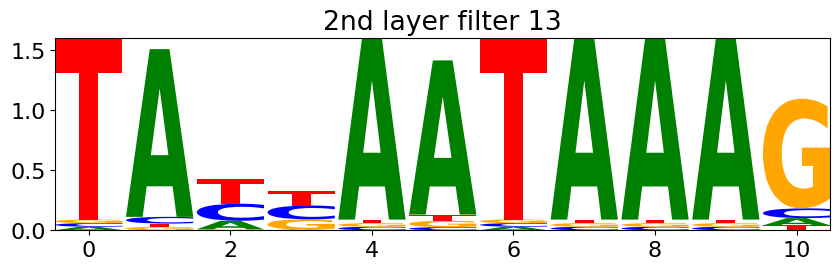

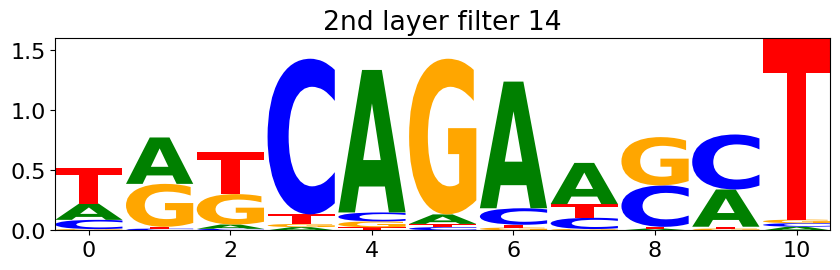

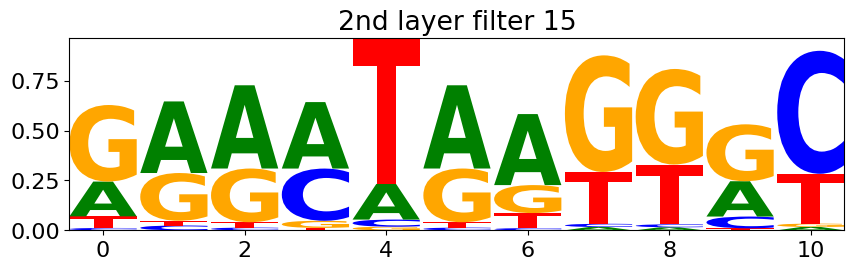

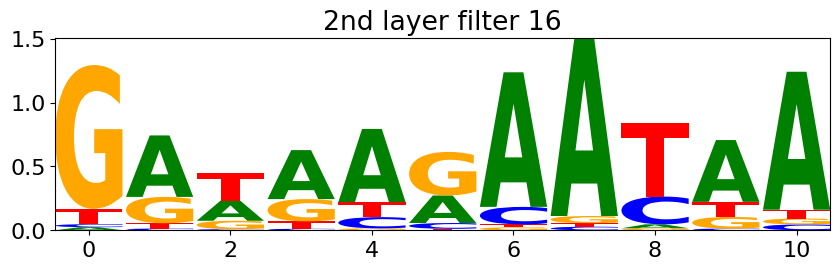

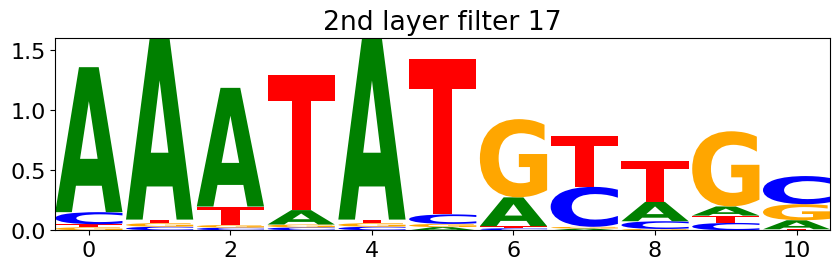

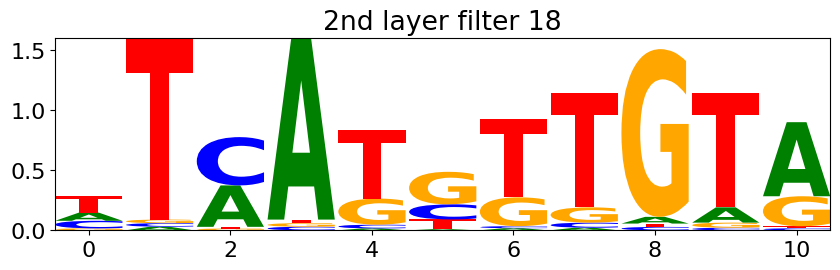

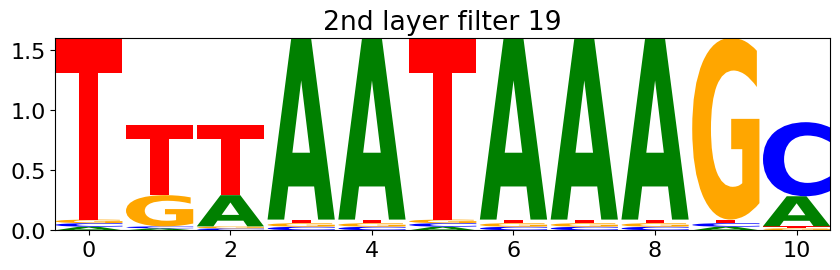

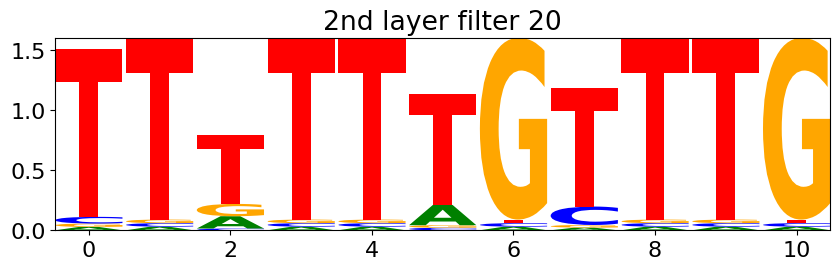

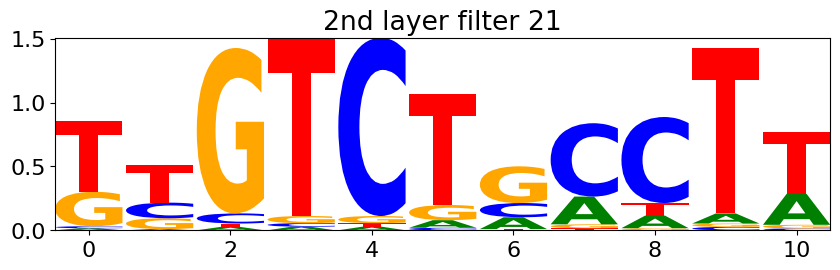

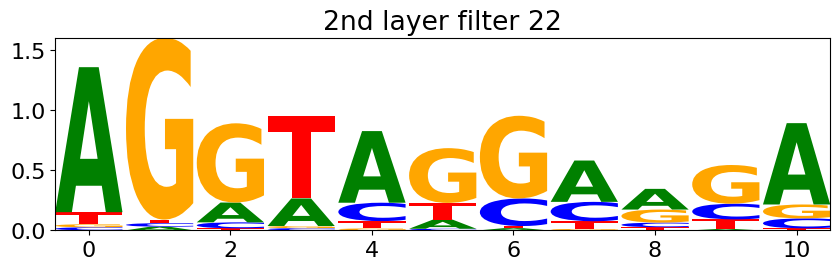

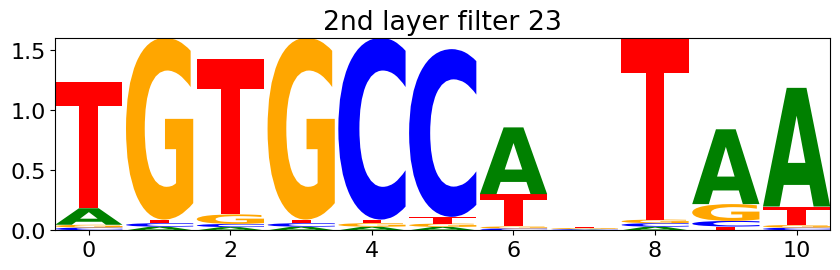

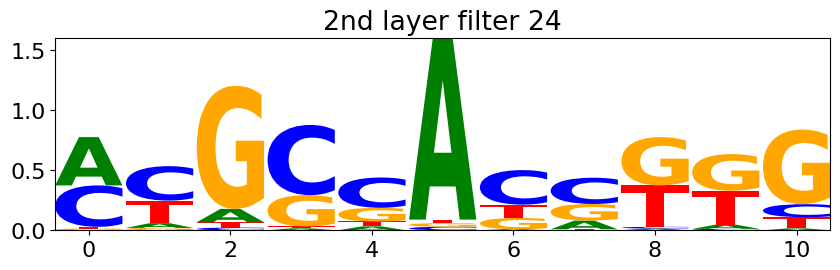

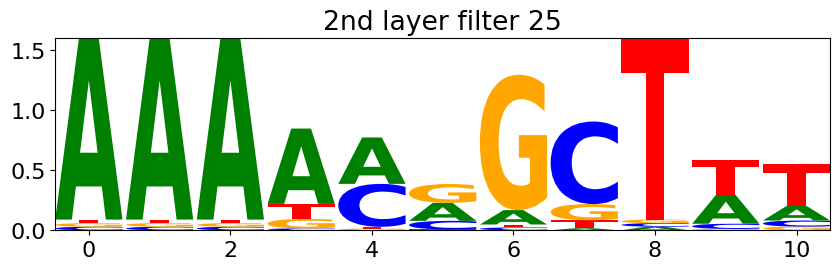

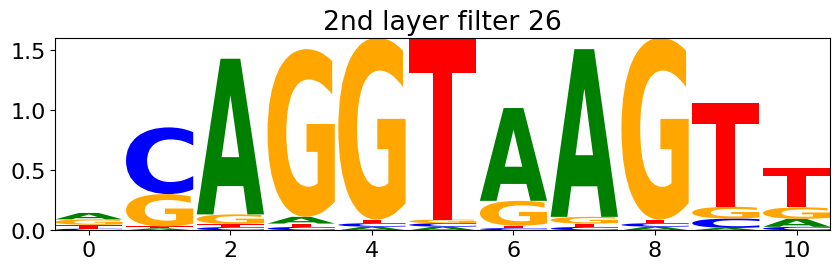

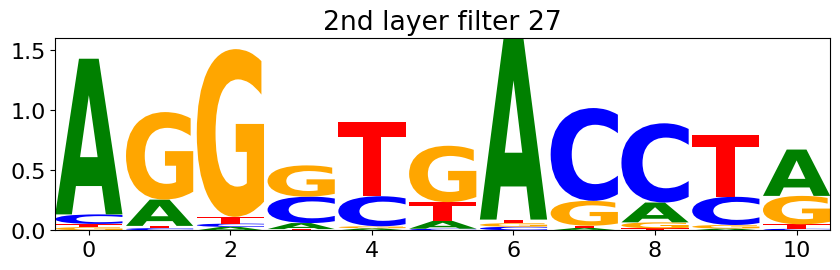

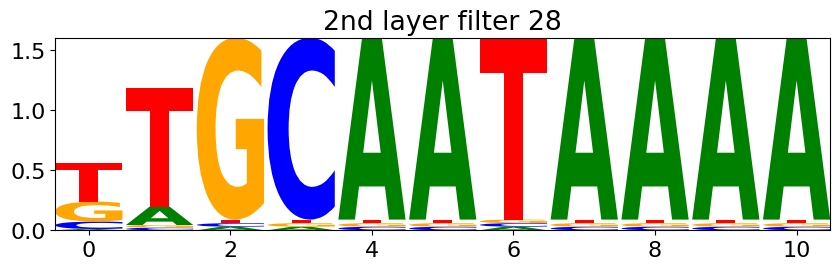

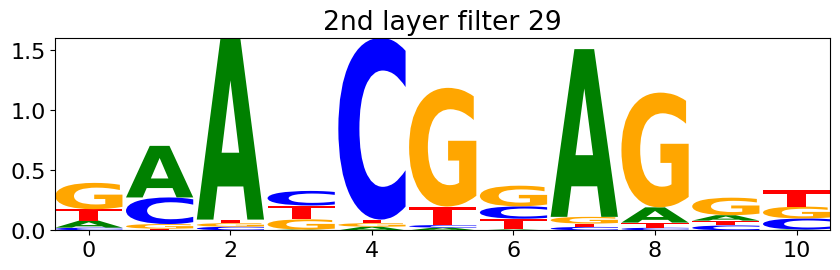

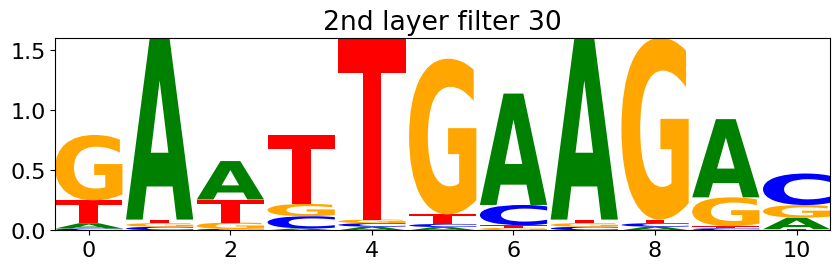

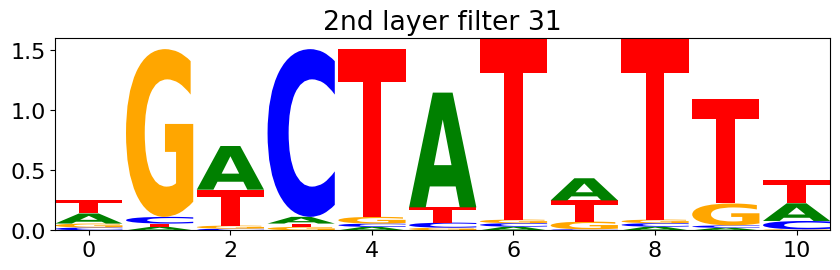

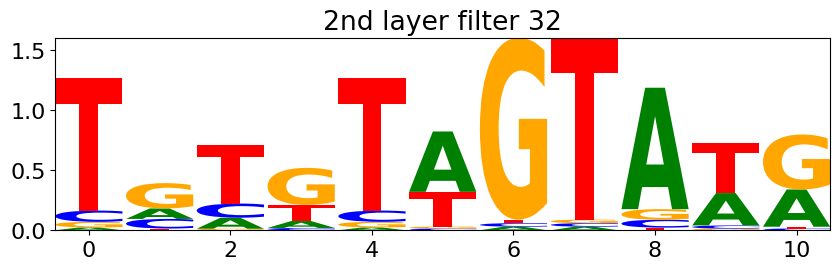

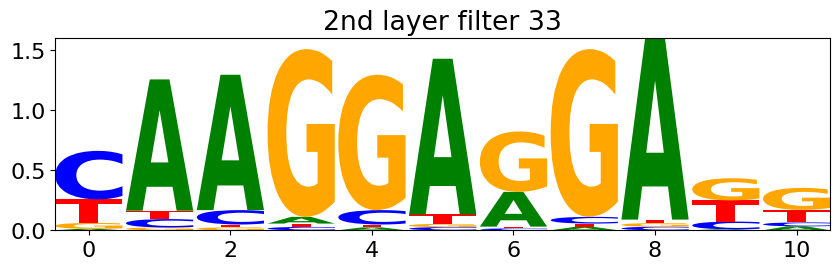

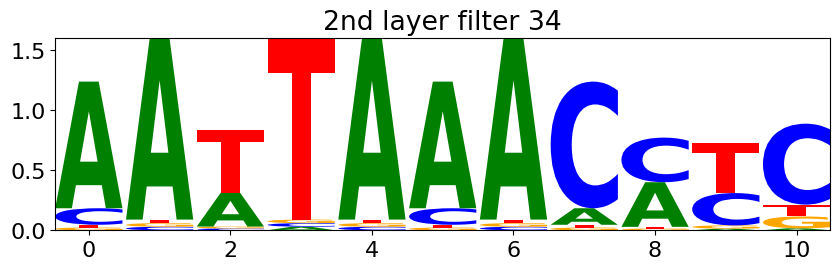

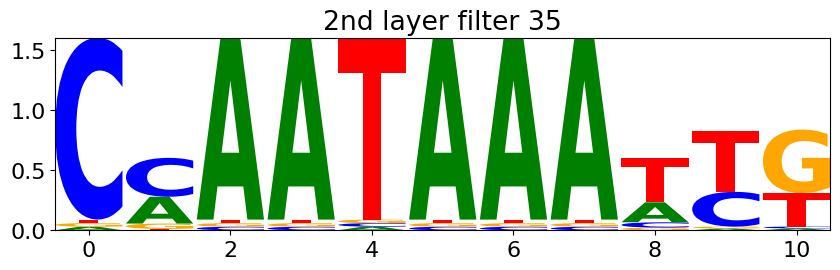

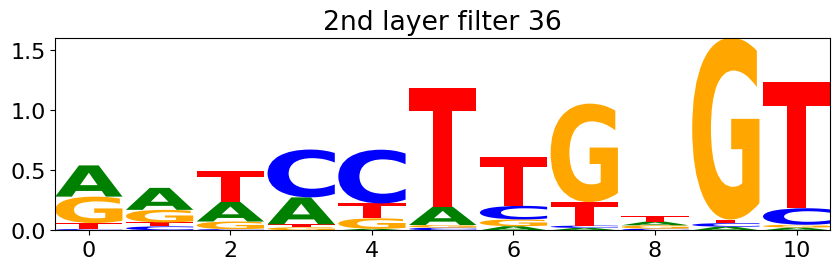

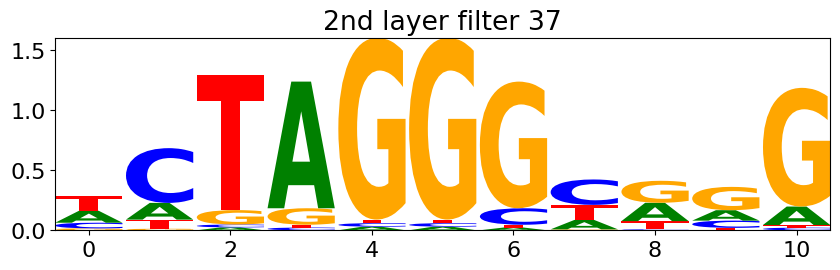

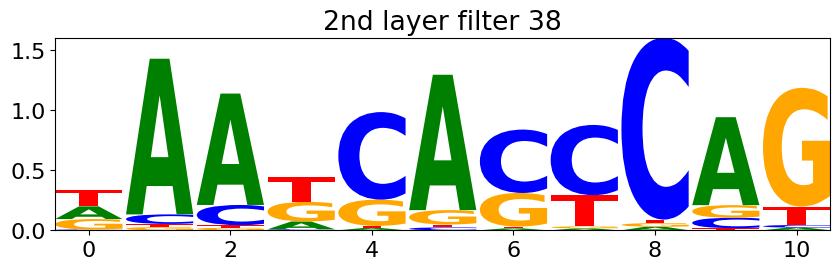

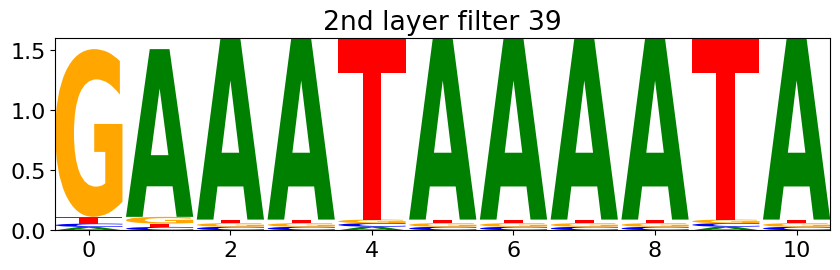

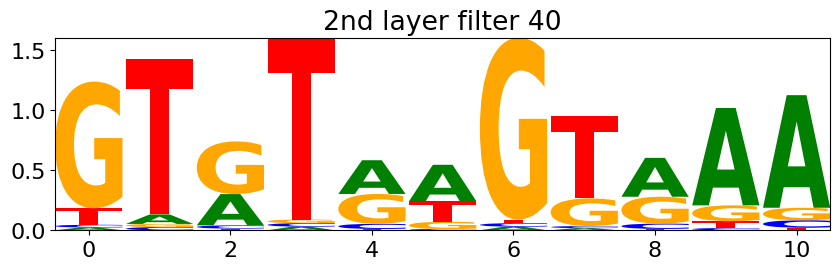

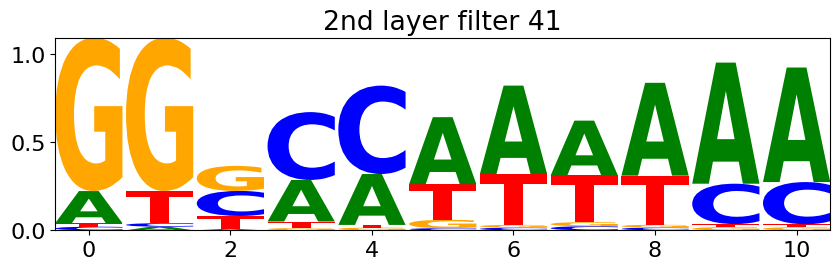

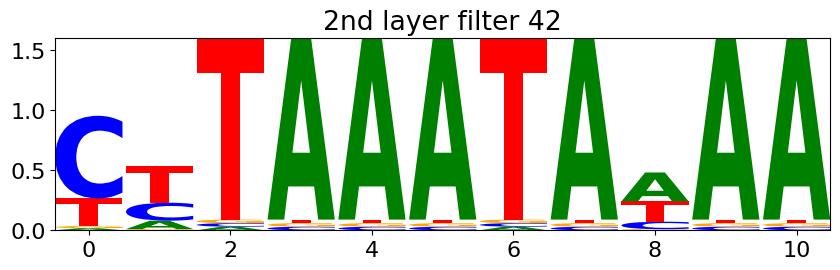

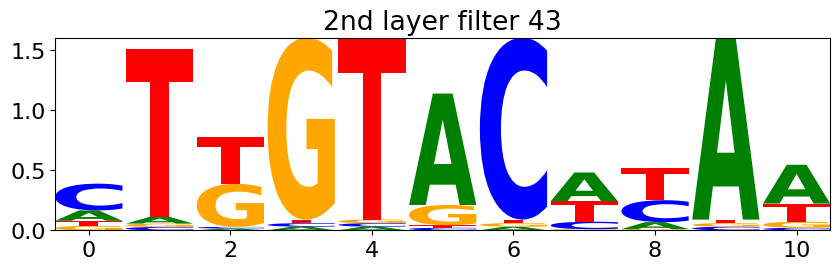

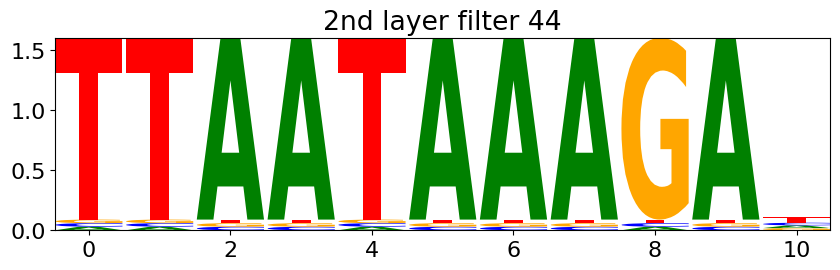

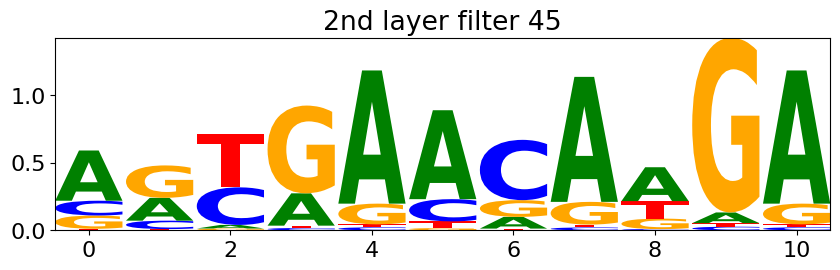

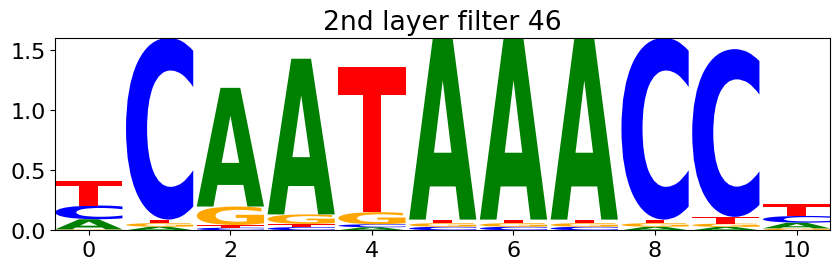

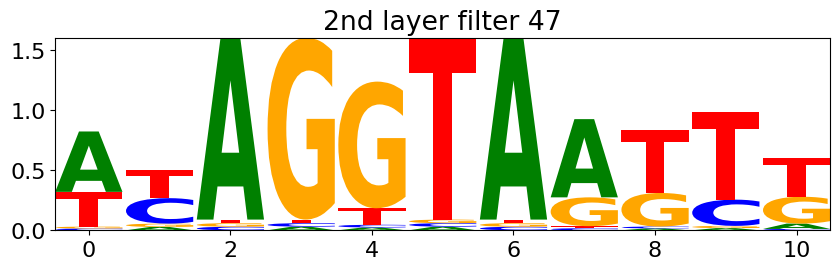

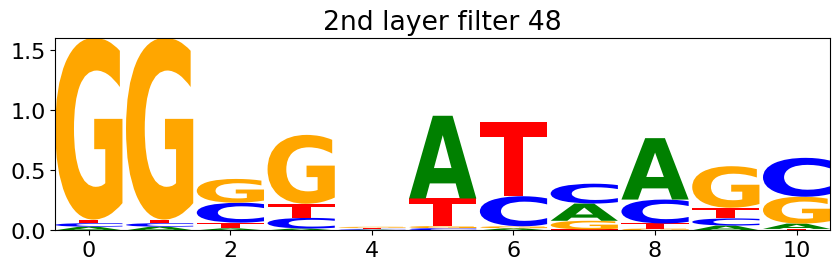

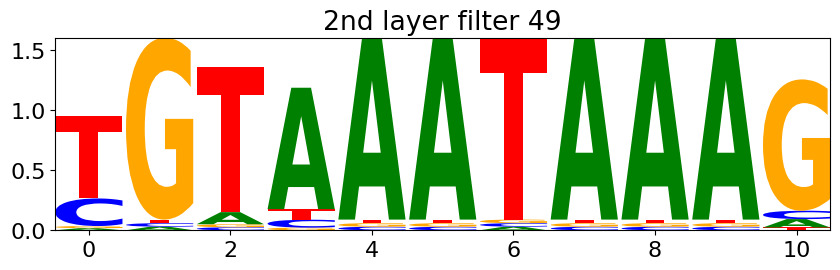

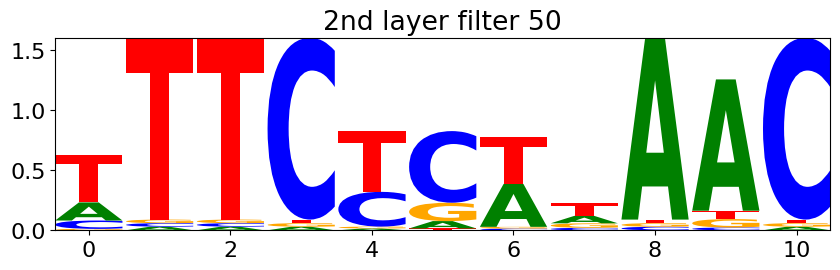

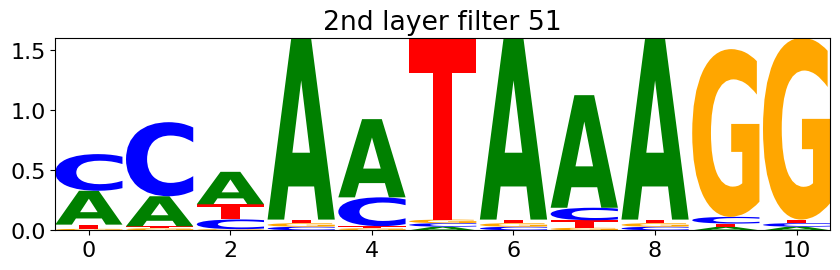

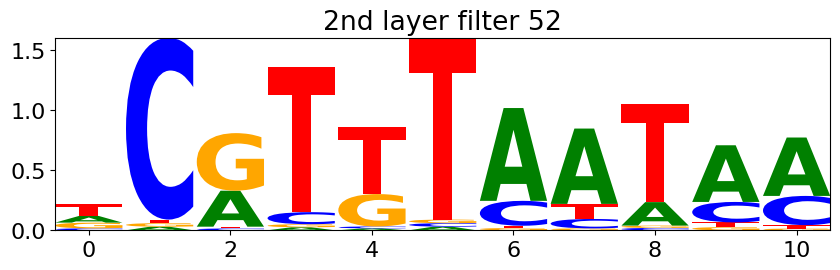

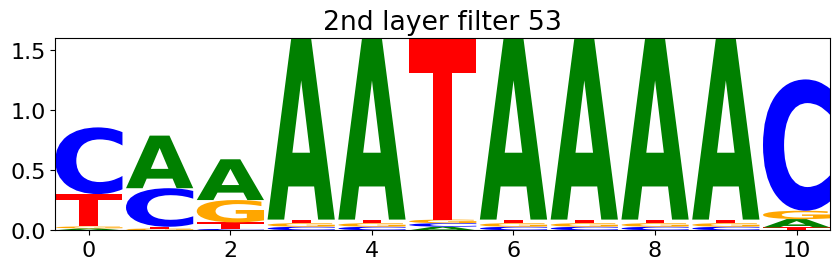

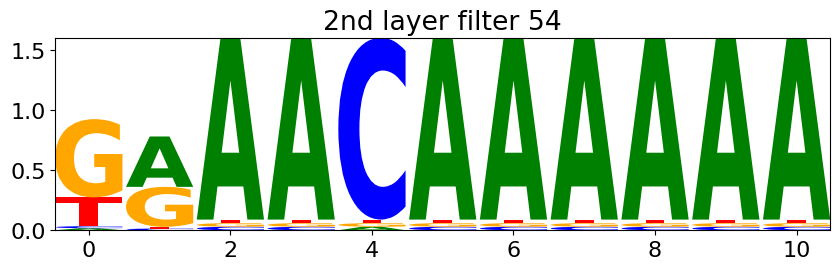

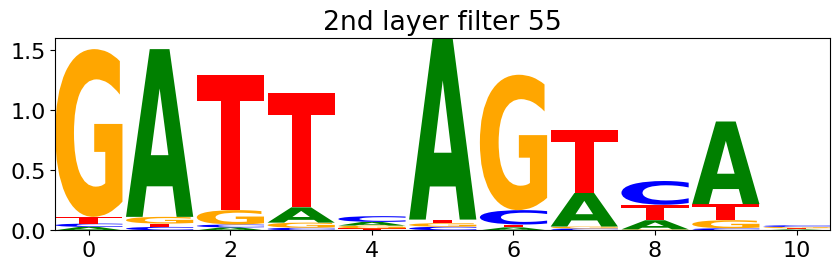

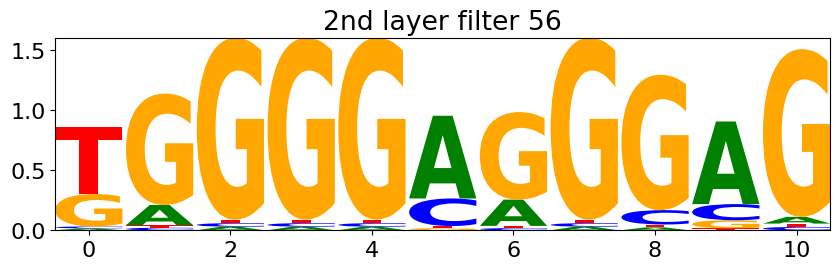

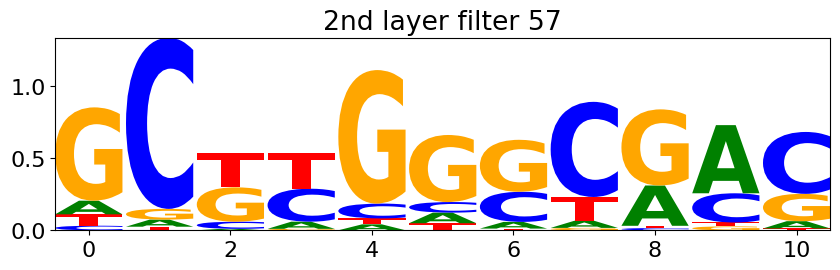

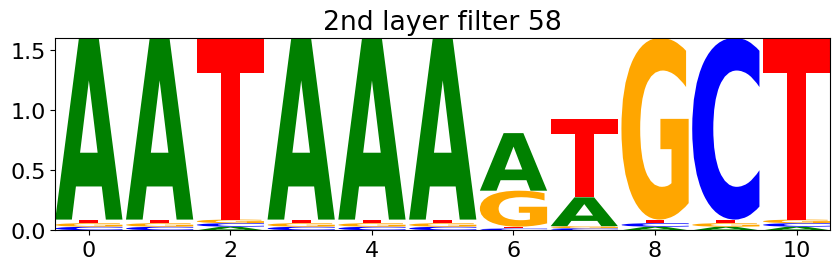

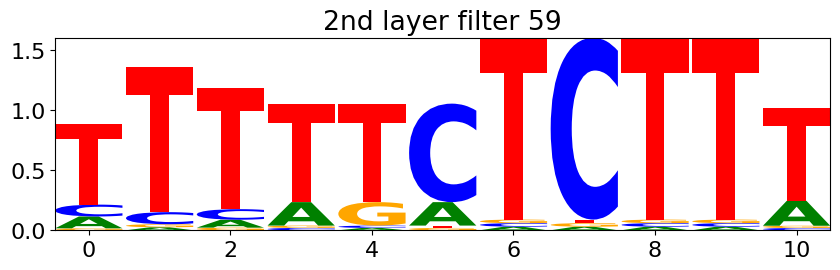

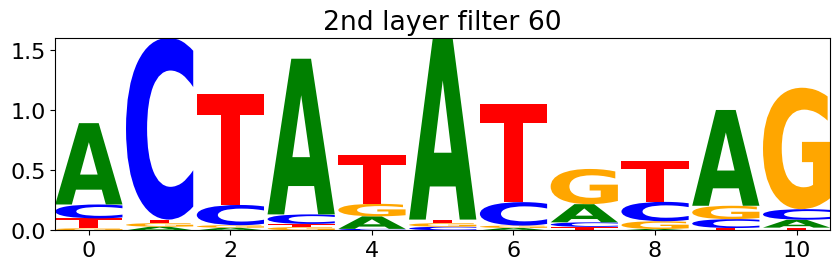

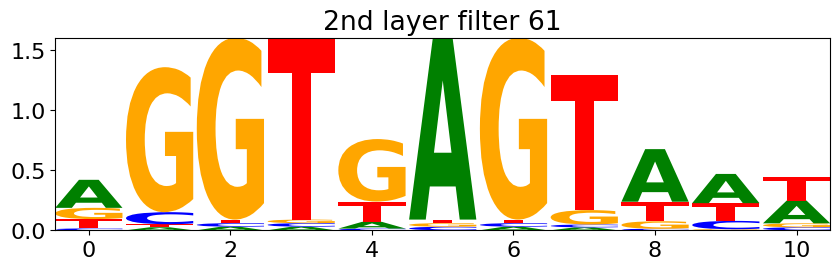

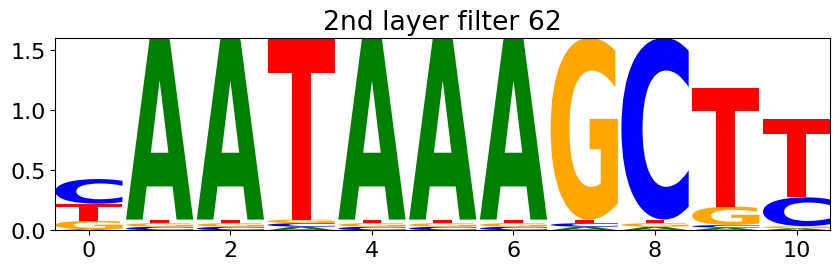

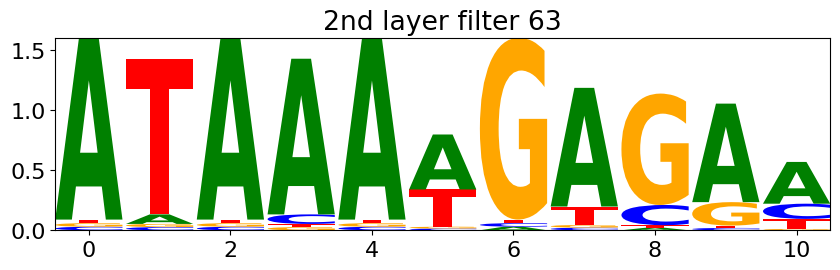

In [44]:
for i in range(0,64):
    plot_motif(i)